# Imports

In [33]:
from matplotlib import pyplot as plt
from scipy.stats import randint
import pandas as pd
import gc
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score , f1_score
from sklearn.metrics import log_loss
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn import linear_model

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_moons, make_blobs, make_circles
import os
import joblib as jl
import librosa
from IPython.display import Audio
from scipy.io import wavfile as wv
import torch
import torch.nn as nn
from tqdm import tqdm # progress ba


import random
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn


import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
import librosa
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from audiomentations import *


from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K



# import Deep learning Libraries
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalMaxPooling2D ,Input, InputLayer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications.vgg19 import VGG19

import albumentations as A
from lazypredict.Supervised import LazyRegressor
import lightgbm as lgb
import optuna
from lightgbm import LGBMRegressor







# 1. What is the model improvement of data-augmentation in regards to different types of data? (audio,images,tabular,tabular (low-dimensionalty))

## 1.1 Creation of synthetic data
The first form of used synthetic data is build upon the generation of random dots in a 2 dimensional plane. The 2 groups of data are generated in 2 groups that are contained within 2 rectangles of data.

In [27]:
def generate_experiment_block_data(low_x1,low_x2,high_x1,high_x2,low_y1,low_y2,high_y1,high_y2,imbalance,amount_of_samples):
    amount_of_samples = 100
    low_x1, high_x1 = 33,64
    low_y1, high_y1 = 0,16
    low_x2, high_x2 = 0,32
    low_y2, high_y2 = 0,16

    rx_1 = randint.rvs(low_x1, high_x1, size=int(amount_of_samples))
    ry_1 = randint.rvs(low_y1, high_y1, size=int(amount_of_samples))
    rx_2 = randint.rvs(low_x2, high_x2, size=int(amount_of_samples/imbalance))
    ry_2 = randint.rvs(low_y2, high_y2, size=int(amount_of_samples/imbalance))
    
    group_nr0 = ["0"] * amount_of_samples
    group_nr1 = ["1"] * int(amount_of_samples/imbalance)
    
    first_group = list(zip(rx_1, ry_1, group_nr0))
    second_group = list(zip(rx_2, ry_2, group_nr1))
    
    for list_elem in second_group:
        first_group.append(list_elem)
        
    block_data = pd.DataFrame(first_group, columns  =['x', 'y', "group"])

    return block_data
    
    

    

## 1.2 Experiment setup
The experiment is done as follows, first the data is generated. Then there are 3 classification algorithms run. The first algorithm will take no measures to solve the class imbalance, the second algorithm will solve this by adjusting the class weights accordingly and the third algorithm will solve this with an algorithm called SMOTE to create extra synthetic data. All these experiments are averaged over 10 trials using a random test-train-split too have a good comparision. Every train test split was done with a halfway cut (50% train, 50% test)

In [37]:

minority_class_imbalance = [2,4,8]
amount_of_samples = 150
low_x1, high_x1 = 33,64
low_y1, high_y1 = 0,16
low_x2, high_x2 = 0,32
low_y2, high_y2 = 0,16

for imbalance in minority_class_imbalance:
    average_acc_none = 0
    average_acc_rand = 0
    average_acc_sm = 0
    
    average_f1_none = 0
    average_f1_rand = 0
    average_f1_sm = 0
    
    
    
    print("imbalance #class1/#class2")
    print(imbalance)
    for random_data in range(0,10):
        block_data = generate_experiment_block_data(33,0,64,32,0,0,16,16,imbalance,amount_of_samples)
        # Take the average over several train-test-splits
        for random_state_idx in range(0,10):

            train, test = train_test_split(block_data, test_size=0.5, random_state= random_state_idx)
            X_train = train.drop(['group'], axis=1)
            X_test = test.drop(['group'], axis=1)

            y_train = train['group']
            y_test = test['group']


            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train, y_train)
            y_pred =  clf.predict(X_test)
            average_acc_none = accuracy_score(y_pred, y_test) + average_acc_none
            average_f1_none = f1_score(y_pred, y_test,  pos_label="1") + average_f1_none

            ros = RandomOverSampler(random_state=42)
            X_res_rand, y_res_rand = ros.fit_resample(X_train, y_train)
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_res_rand, y_res_rand)
            y_pred =  clf.predict(X_test)
            average_acc_rand = accuracy_score(y_pred, y_test) + average_acc_rand
            average_f1_rand = f1_score(y_pred, y_test, pos_label="1") + average_f1_rand

            sm = SMOTE(random_state=42, k_neighbors=3)
            X_res_sm, y_res_sm = sm.fit_resample(X_train, y_train)
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_res_sm, y_res_sm)
            y_pred =  clf.predict(X_test)
            average_acc_sm = accuracy_score(y_pred, y_test) + average_acc_sm
            average_f1_sm = f1_score(y_pred, y_test, pos_label="1") + average_f1_sm


    print("Averaged score for no resampling: ")
    print(average_acc_none/100)

    print("Averaged score for rand resampling: ")
    print(average_acc_rand/100)

    print("Averaged score for smote resampling: ")
    print(average_acc_sm/100)
    
    
    print("f1 score for no resampling: ")
    print(average_f1_none/100)

    print("f1 score for rand resampling: ")
    print(average_f1_rand/100)

    print("f1 score for smote resampling: ")
    print(average_f1_sm/100)



    

imbalance #class1/#class2
2
Averaged score for no resampling: 
0.9773333333333326
Averaged score for rand resampling: 
0.978666666666666
Averaged score for smote resampling: 
0.9801333333333326
f1 score for no resampling: 
0.962581464572403
f1 score for rand resampling: 
0.9662471495103121
f1 score for smote resampling: 
0.9687223697103134
imbalance #class1/#class2
4
Averaged score for no resampling: 
0.9776190476190467
Averaged score for rand resampling: 
0.9717460317460305
Averaged score for smote resampling: 
0.977142857142856
f1 score for no resampling: 
0.9337102555787211
f1 score for rand resampling: 
0.9230462683129315
f1 score for smote resampling: 
0.9341072991290933
imbalance #class1/#class2
8
Averaged score for no resampling: 
0.9801785714285708
Averaged score for rand resampling: 
0.9719642857142855
Averaged score for smote resampling: 
0.9791071428571426
f1 score for no resampling: 
0.8492524142524135
f1 score for rand resampling: 
0.8451801744007622
f1 score for smote res

* Note when rerunning the experiment, scores may vary
* Scores are based on the accuracy-score: $\frac{True_{neg} + True_{pos}}{True_{pos} + False_{neg} + True_{neg} + False_{pos}}$
| Accuracy   | no resampling  | random resampling  | Smote resampling  |
|---|---|---|---|
| Class imbalance 1/2  | 0.971  | 0.973  | 0.971  |
| Class imbalance 1/4   | 0.974  | 0.967  | 0.972  |
| Class imbalance 1/8   | 0.980  | 0.967  | 0.976  |

Using these observations, there is always a benefit by never solving the imbalance and fitting the clasifier with the data as is.




To have a score-function that takes more the class imbalance into account we use the f1-score as a scoring function, this has following results:
$$ Precision = \frac{ True_{pos} }{ True_{pos} + False_{pos} } $$

$$ Recall = \frac{True_{pos}}{True_{pos} + False_{neg}} $$

$$F_1 = 2 *  \frac{Precision * Recall}{Precision + Recall}$$


<center> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png"  width="300" height="150"></center>



| f1-score   | no resampling  | random resampling  | Smote resampling  |
|---|---|---|---|
| Class imbalance 1/2  | 0.962  | 0.966  | 0.968  |
| Class imbalance 1/4   | 0.933  | 0.923  | 0.934  |
| Class imbalance 1/8   | 0.849  | 0.845  | 0.861  |

Using the f1-scoring it can be seen that SMOTE-resampling performs better in all 3 occasions, with more gain at higher rates of imbalance.

## 1.3 Creation of synthetic data (Using sklearn)


-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
Imbalance rate: 
2
-------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------
Type of dataset: 
moons
-------------------------------------------------------------------------------------------------------
Type of oversampler:
No sampling 
Average score: 
0.9640000000000001
-------------------------------------------------------------------------------------------------------
Type of oversampler:
Random sampler 
Average score: 
0.9

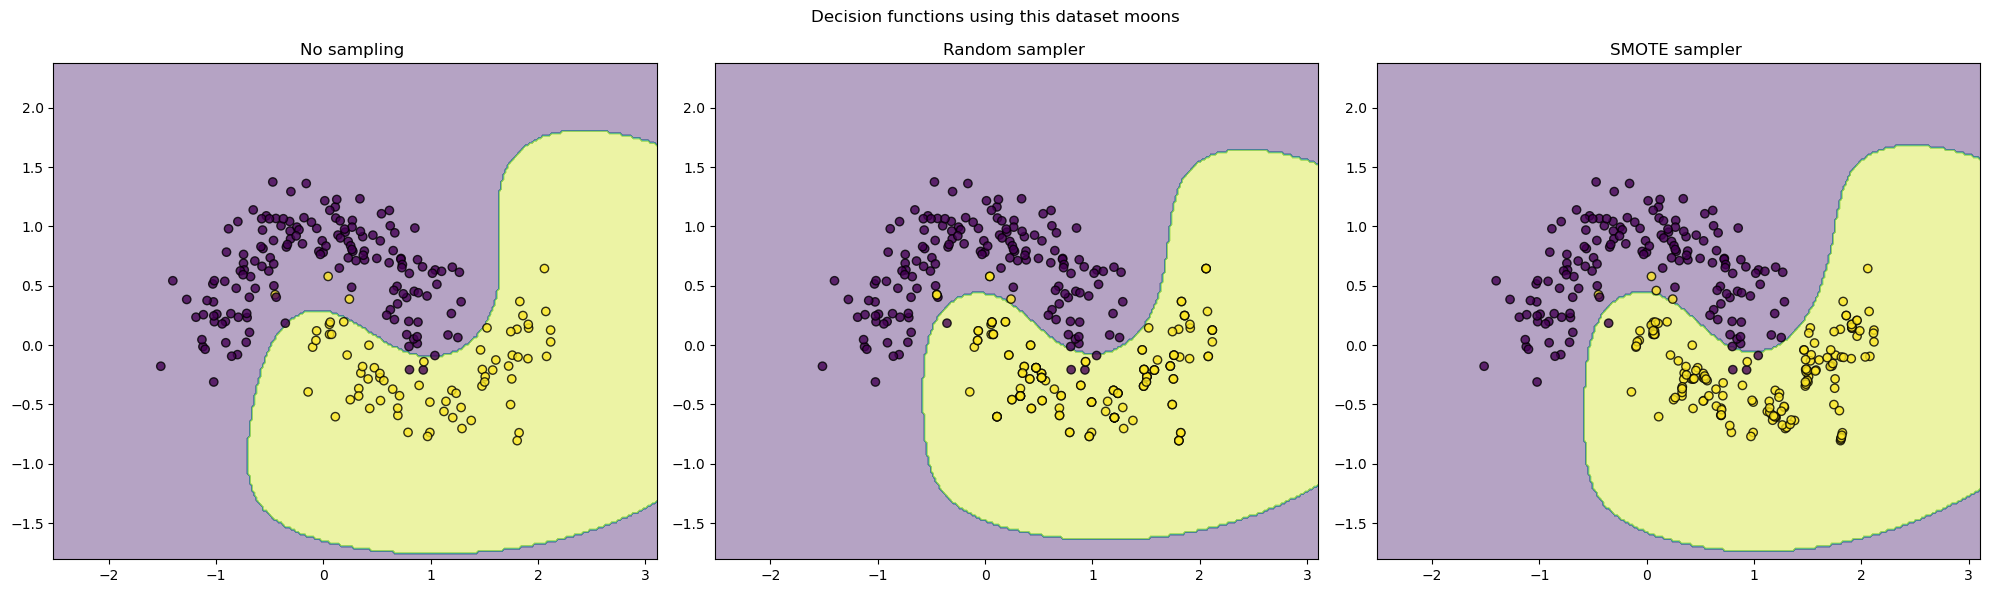

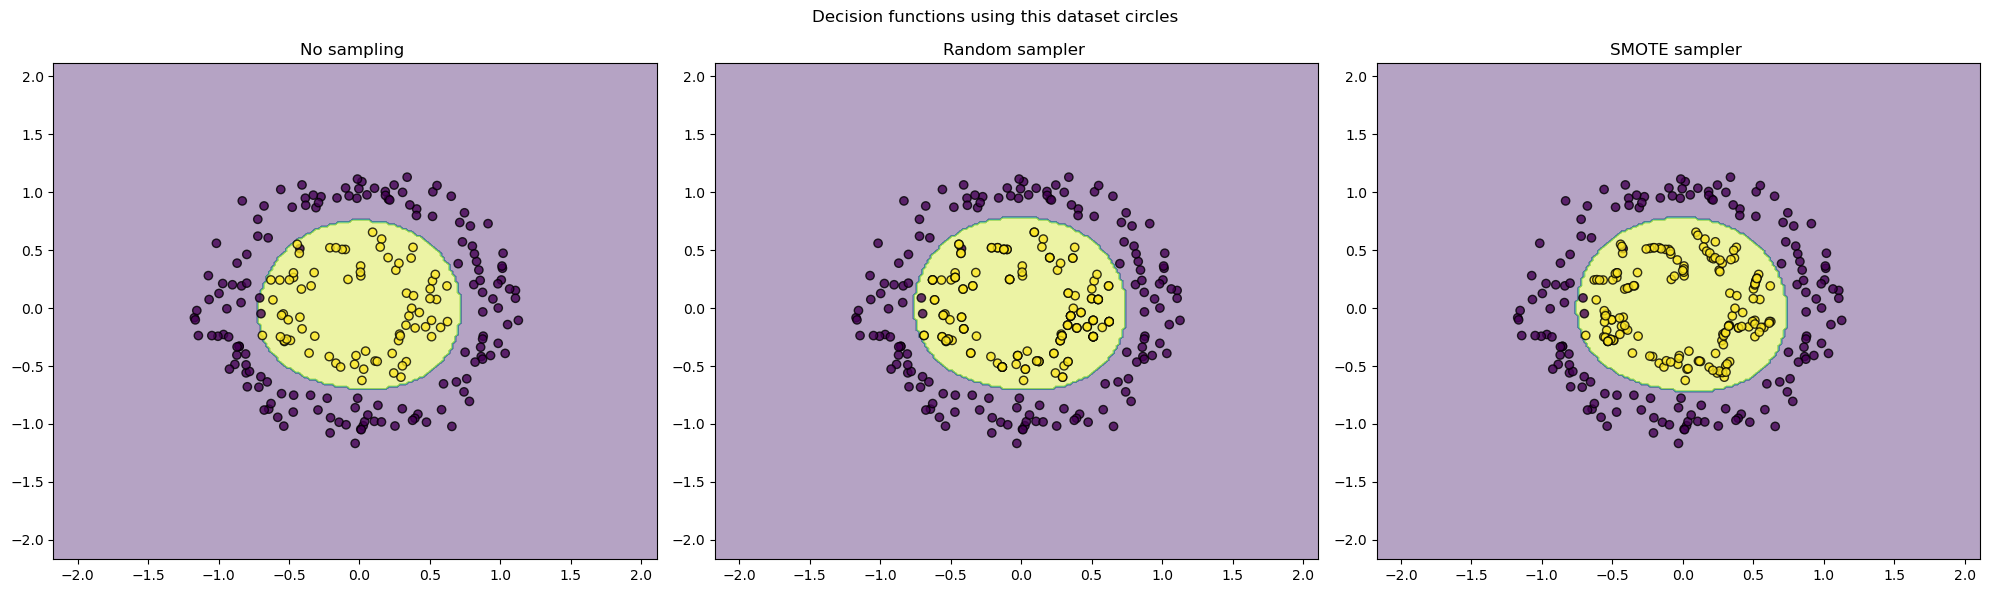

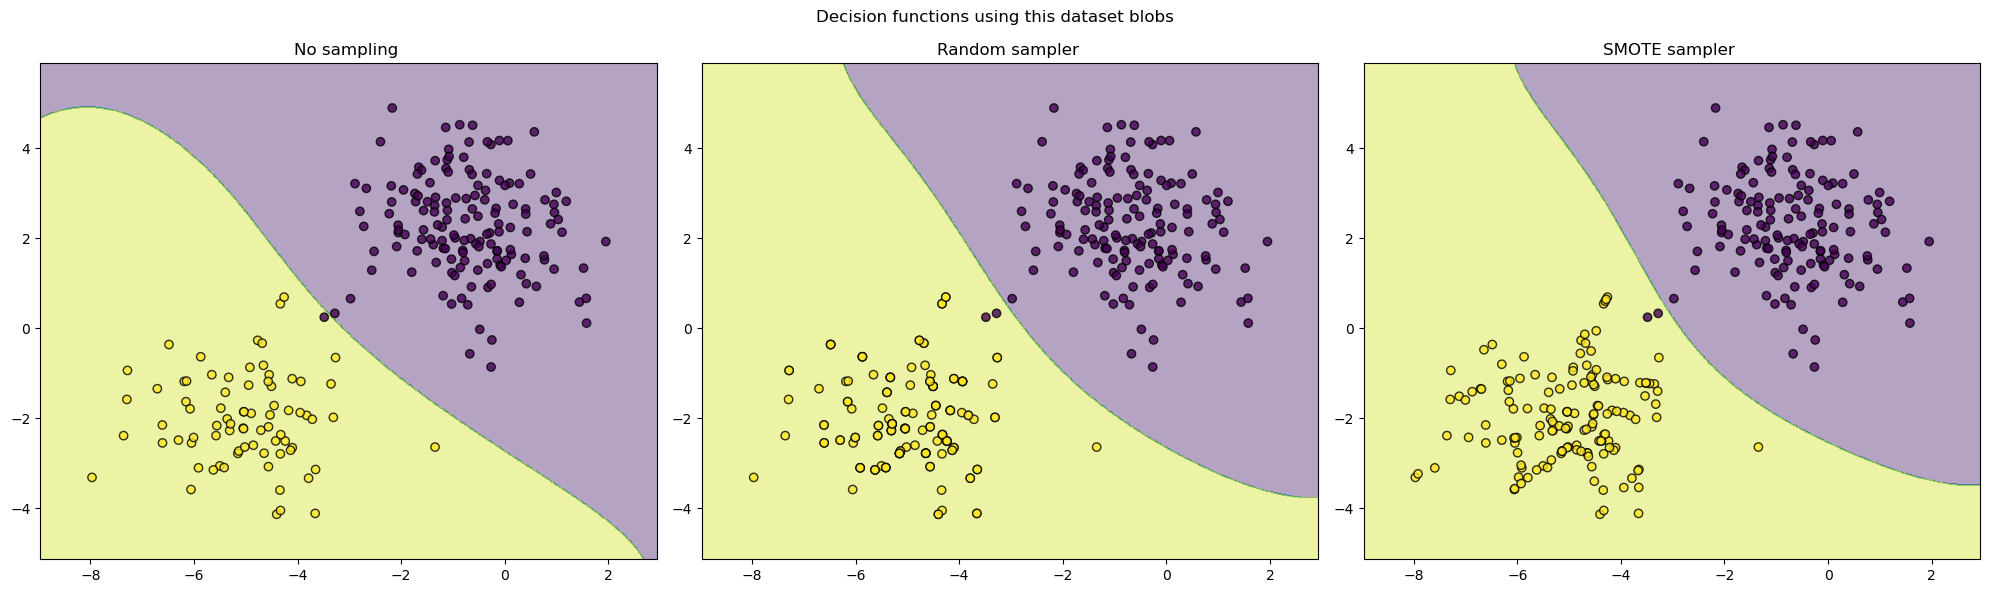

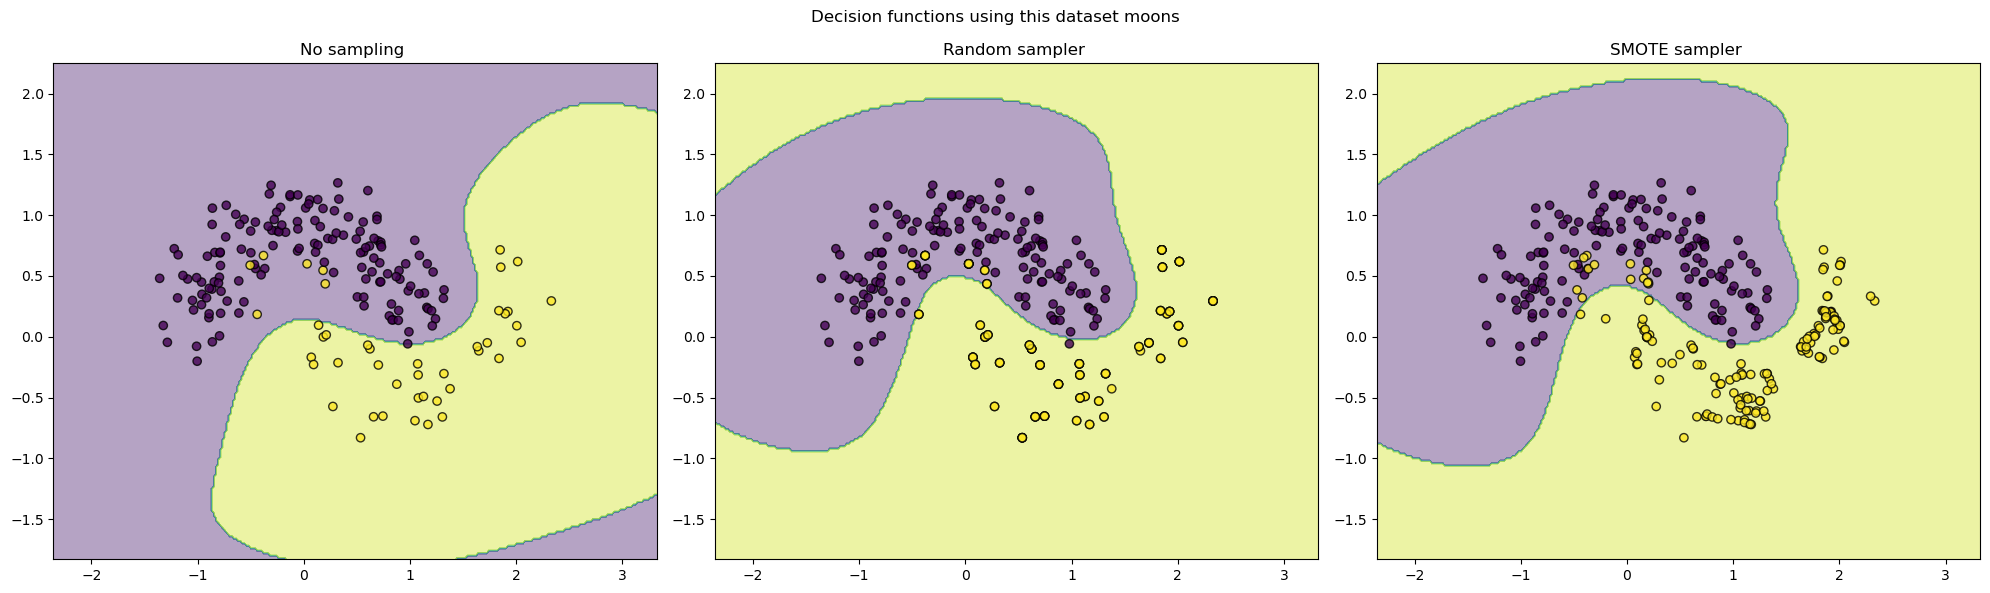

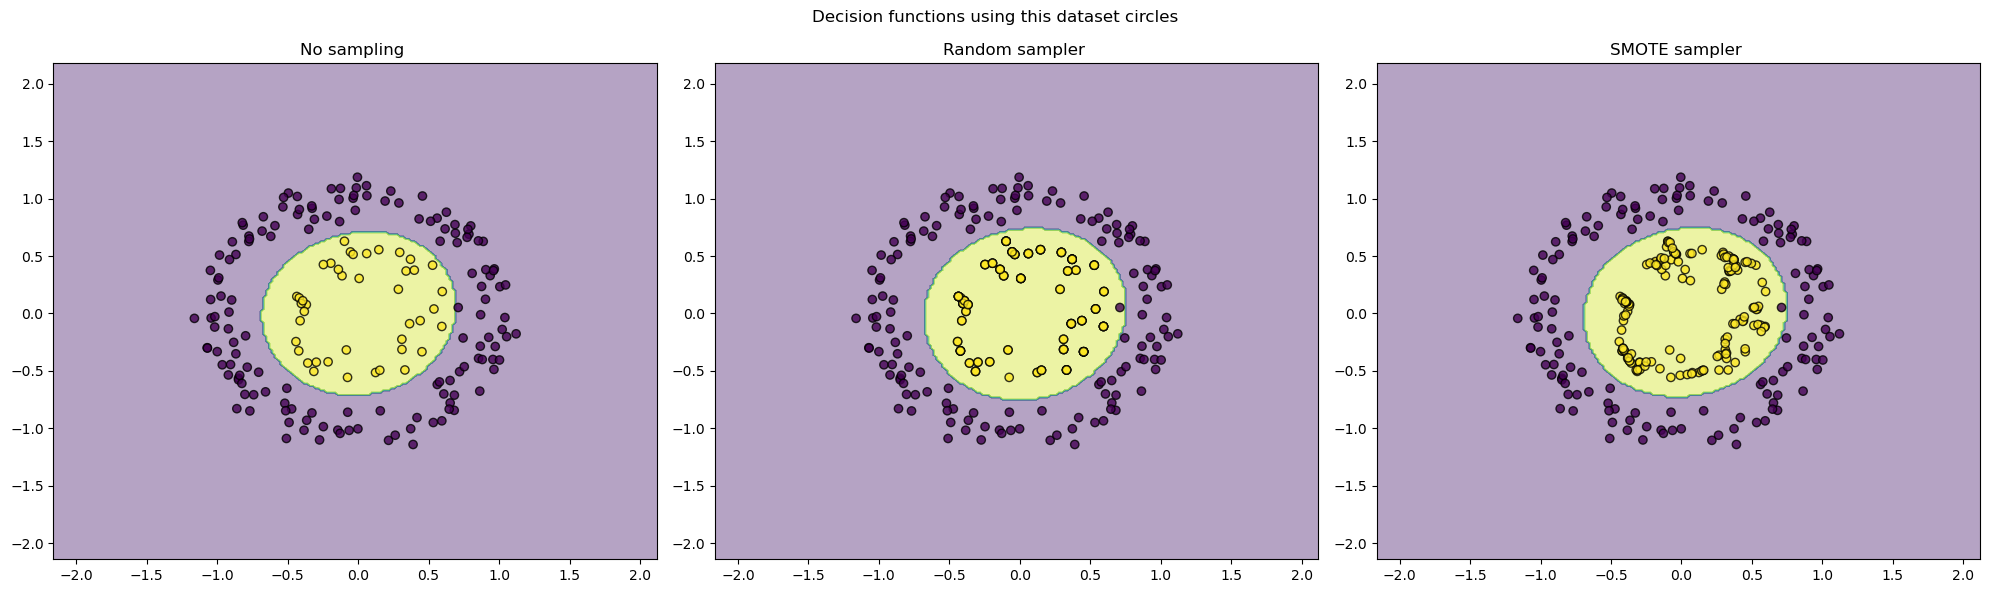

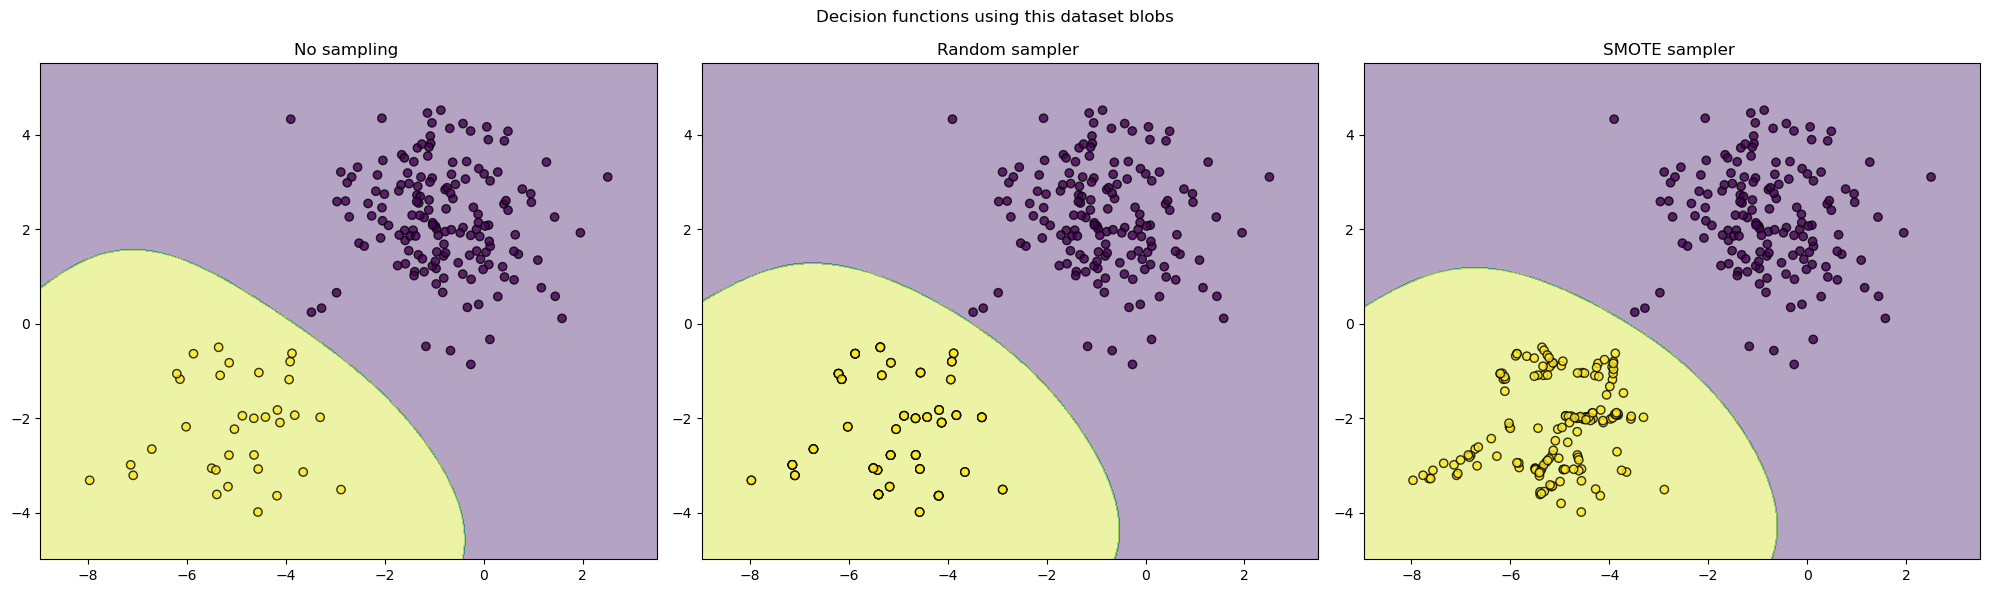

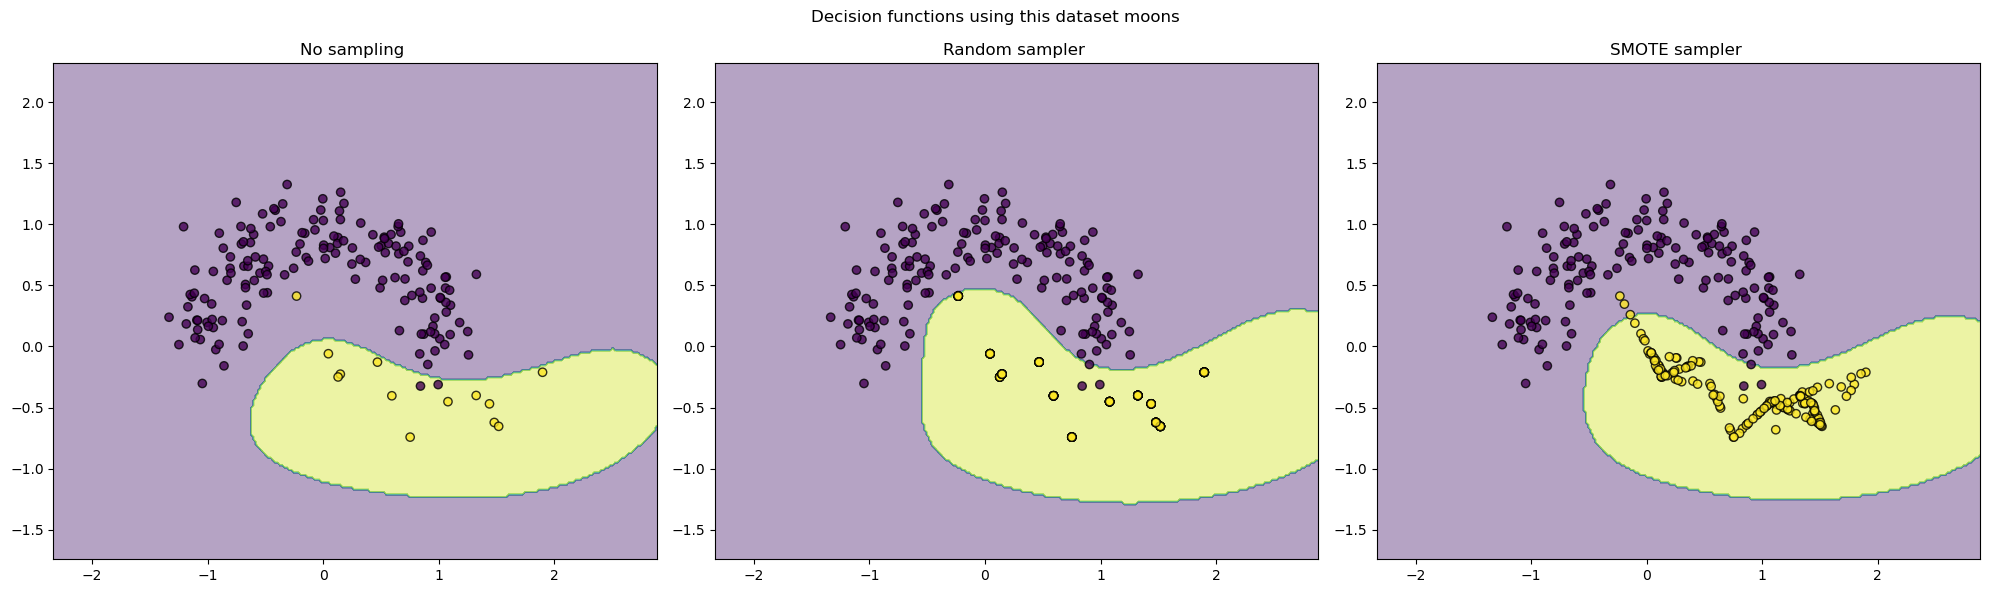

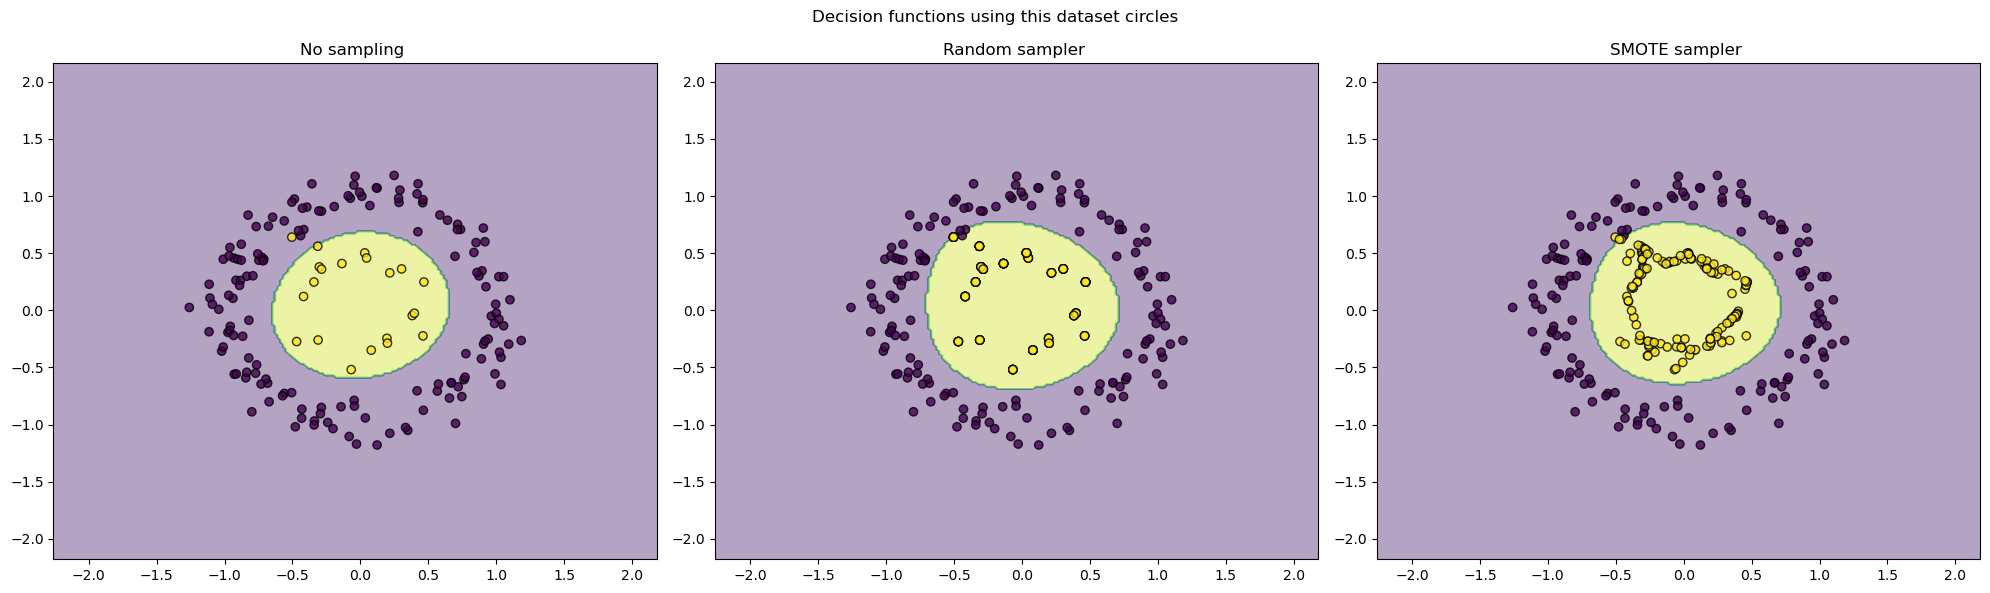

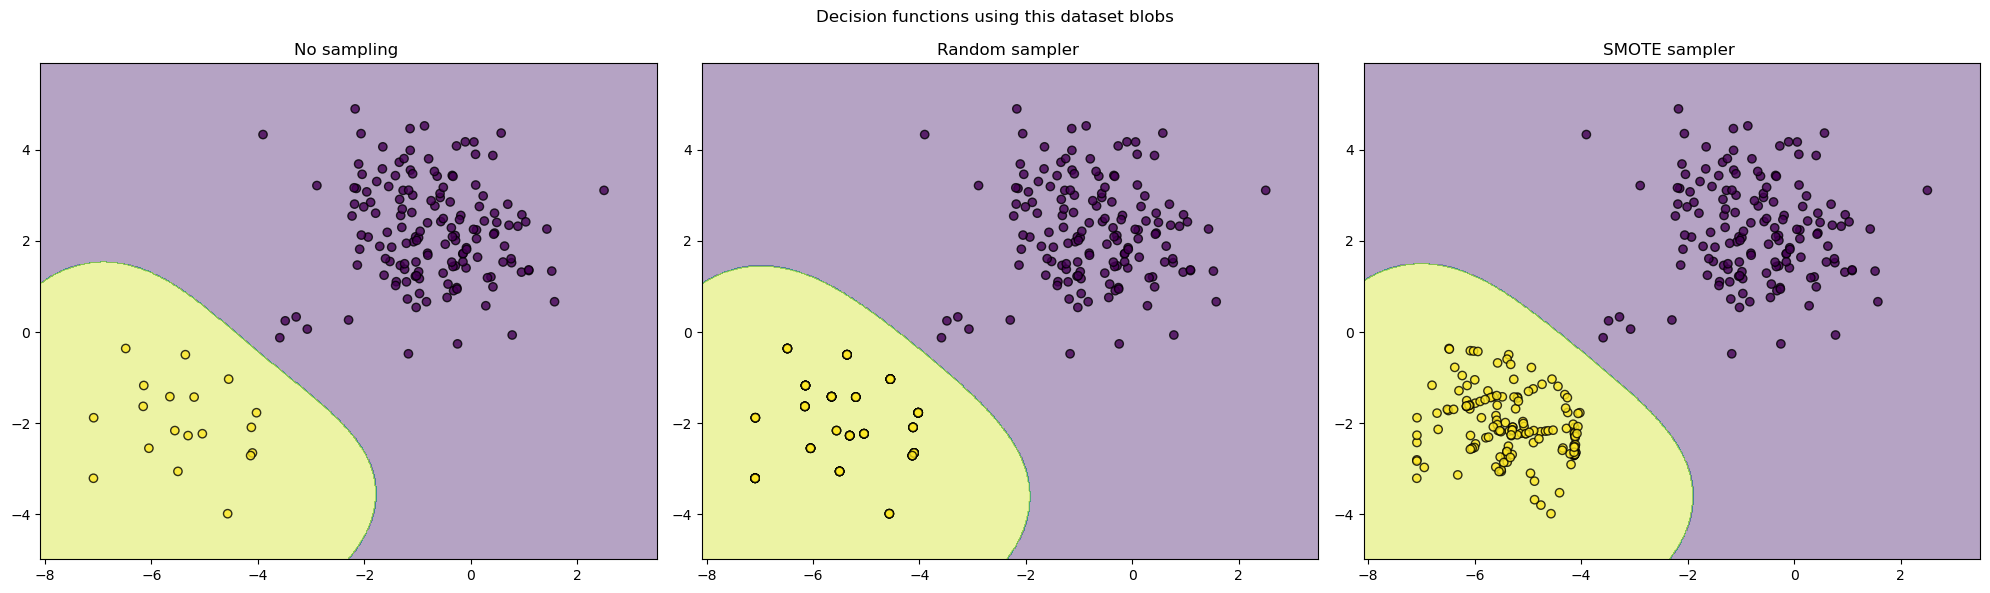

In [96]:
from imblearn.pipeline import make_pipeline


def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    if title is not None:
        ax.set_title(title)



minority_class_imbalance = [2,4,8]

amount_of_samples = 300


models = {
    "No sampling ": make_pipeline(StandardScaler(),SVC(gamma='auto')),
    "Random sampler ": make_pipeline(StandardScaler(),RandomOverSampler(random_state=42),SVC(gamma='auto')),
    "SMOTE sampler ": make_pipeline(StandardScaler(),SMOTE(random_state=42),SVC(gamma='auto')),
}

for imbalance in minority_class_imbalance:
    print("-------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------------------------------")
    print("Imbalance rate: ")
    print(imbalance)
    datasets = [
        make_moons(noise=0.2, random_state=0, n_samples=[amount_of_samples,int(amount_of_samples/imbalance)]),
        make_circles(noise=0.1, factor=0.5, random_state=1, n_samples=[amount_of_samples,int(amount_of_samples/imbalance)]),
        make_blobs( random_state=1,  center_box=[-5,5] , cluster_std= 1.1, n_samples=[amount_of_samples,int(amount_of_samples/imbalance)])
    ]
    datasets_name = ["moons", "circles", "blobs"]
    
    for ds_cnt, ds in enumerate(datasets):
        print("-------------------------------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------------------------------")
        print("Type of dataset: ")
        print(datasets_name[ds_cnt])
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
        for ax , (title,model) in zip(axs, models.items()):
            
            average_score = 0
            print("-------------------------------------------------------------------------------------------------------")
            print("Type of oversampler:")
            print(title)
            for random_state_idx in range(0,10):
                X, y = ds
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.5, random_state=random_state_idx
                )
                model.fit(X_train, y_train)
                
                y_pred =  model.predict(X_test)
                average_score = average_score + accuracy_score(y_pred, y_test)
            if title == "No sampling ":

                plot_decision_function(X_train, y_train, model, ax=ax, title=title)
                
            elif title == "Random sampler ":
                ros = RandomOverSampler(random_state=42)
                X_res, y_res = ros.fit_resample(X_train, y_train)
                plot_decision_function(X_res, y_res, model, ax=ax, title=title)
                
            
            elif title == "SMOTE sampler ":
                ros = SMOTE(random_state=42)
                X_res, y_res = ros.fit_resample(X_train, y_train)
                plot_decision_function(X_res, y_res, model, ax=ax, title=title)
                
                
            print("Average score: ")
            print(average_score/10)
        fig.suptitle("Decision functions using this dataset " + datasets_name[ds_cnt])
        fig.tight_layout()
                

        
    
    
    

# Audio

In [97]:
#https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs?datasetId=2749&sortBy=voteCount




In [98]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(128,128,3),
                            include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(2, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.save_weights('model.h5')

In [99]:


train_dir = 'catvsdog/cats_dogs/train'
test_dir = 'catvsdog/cats_dogs/test'
train_paths=[]
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        train_paths+=[(os.path.join(dirname, filename))]
test_paths=[]
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        test_paths+=[(os.path.join(dirname, filename))]

In [100]:
Name=['dog','cat']
N=list(range(len(Name)))    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name))
Wrong_Name=['test','cats']
fix_mapping=dict(zip(Wrong_Name,Name))





def TSNE_visualization(model, testX, title):


    model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    features = model2(testX)
    features = np.nan_to_num(features)
    labels = np.argmax(model(testX), axis=-1)
    tsne = TSNE(n_components=2).fit_transform(features)

    def scale_to_01_range(x):

        value_range = (np.max(x) - np.min(x))
        starts_from_zero = x - np.min(x)
        return starts_from_zero / value_range
    print("The Labels")
    print(labels)
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    colors = ['red', 'blue']
    classes = ["cat" , "dog"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, c in enumerate(colors):
        indices = [i for i, l in enumerate(labels) if idx == l]
        print("The tx")
        print(tx)
        print("The indices")
        print(indices)
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

    ax.legend(loc='best')
    plt.title(title)
    plt.show()
    

C:\Users\Stefano\AppData\Local\Temp\ipykernel_15832\235712720.py:25: RuntimeWarning: invalid value encountered in true_divide
  X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
C:\Users\Stefano\AppData\Local\Temp\ipykernel_15832\235712720.py:40: RuntimeWarning: invalid value encountered in true_divide
  X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


Epoch 1/5
7/7 [==============================] - 15s 945ms/step - loss: 1.9586 - accuracy: 0.6048 - val_loss: 1.2884 - val_accuracy: 0.8507
Epoch 2/5
7/7 [==============================] - 3s 409ms/step - loss: 0.5866 - accuracy: 0.8667 - val_loss: 0.7478 - val_accuracy: 0.8657
Epoch 3/5
7/7 [==============================] - 3s 455ms/step - loss: 0.3786 - accuracy: 0.8905 - val_loss: 0.4590 - val_accuracy: 0.8955
Epoch 4/5
7/7 [==============================] - 3s 482ms/step - loss: 0.2266 - accuracy: 0.9429 - val_loss: 0.4119 - val_accuracy: 0.8657
Epoch 5/5
3/3 [==============================] - 3s 176ms/step
              precision    recall  f1-score   support

         dog     0.8065    0.8929    0.8475        28
         cat     0.9167    0.8462    0.8800        39

    accuracy                         0.8657        67
   macro avg     0.8616    0.8695    0.8637        67
weighted avg     0.8706    0.8657    0.8664        67



C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The Labels
[1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0
 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
The tx
[0.7593547  0.42999455 0.57589614 0.4674325  0.6043083  0.08266398
 0.21184328 0.3588011  0.06801327 0.07838771 0.47820678 0.
 0.32857278 0.38922608 0.18455328 0.4498793  0.30074143 0.18962549
 0.50124246 0.5700053  0.5076563  0.33654404 0.40211743 0.00568221
 0.26505733 0.34554476 0.30319187 0.3786975  0.50883627 0.5170398
 0.8390595  0.7923334  0.34380865 0.56935716 0.451834   0.38522705
 0.25934327 0.4161337  0.5970992  0.26699972 0.59804326 0.70835155
 0.64591044 0.70580137 0.50345963 0.86530524 0.9563346  0.98552
 0.9955565  1.         0.9203775  0.8264741  0.90252227 0.6822851
 0.83696395 0.7689775  0.7884586  0.6089872  0.8446472  0.91332346
 0.21223153 0.76084346 0.8461149  0.45789587 0.81150347 0.7632879
 0.7176526 ]
The indices
[4, 5, 8, 9, 11, 15, 23, 29, 31, 36, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 

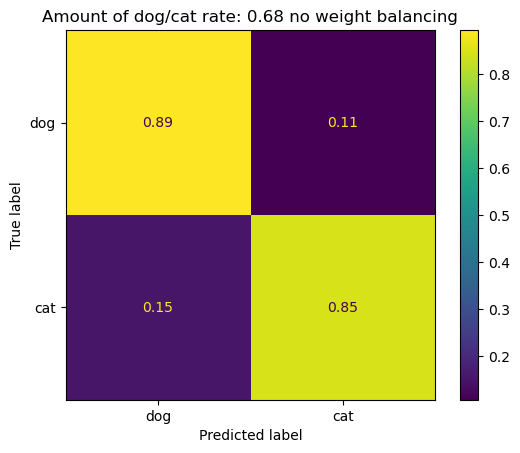

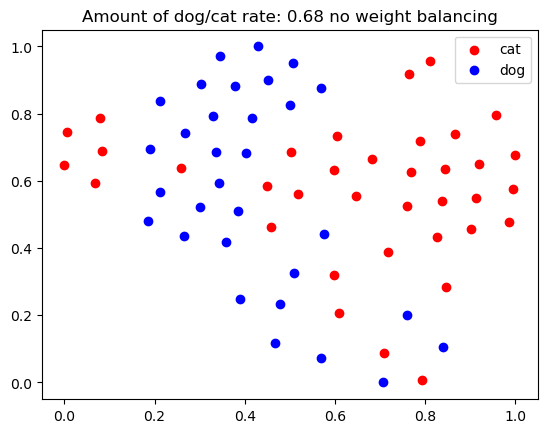

Epoch 1/50
7/7 [==============================] - 11s 811ms/step - loss: 1.8808 - accuracy: 0.5952 - val_loss: 0.9638 - val_accuracy: 0.7015
Epoch 2/50
7/7 [==============================] - 3s 475ms/step - loss: 0.9587 - accuracy: 0.7524 - val_loss: 0.8060 - val_accuracy: 0.8507
Epoch 3/50
7/7 [==============================] - 3s 485ms/step - loss: 0.4499 - accuracy: 0.8714 - val_loss: 0.5870 - val_accuracy: 0.8806
Epoch 4/50
7/7 [==============================] - 3s 458ms/step - loss: 0.1955 - accuracy: 0.9333 - val_loss: 0.5799 - val_accuracy: 0.8806
Epoch 5/50
7/7 [==============================] - 3s 445ms/step - loss: 0.1381 - accuracy: 0.9476 - val_loss: 0.5653 - val_accuracy: 0.8209
Epoch 6/50
7/7 [==============================] - 3s 416ms/step - loss: 0.1528 - accuracy: 0.9333 - val_loss: 0.4812 - val_accuracy: 0.9104
Epoch 7/50
7/7 [==============================] - 3s 476ms/step - loss: 0.0388 - accuracy: 0.9857 - val_loss: 0.5344 - val_accuracy: 0.8955
Epoch 8/50
7/7 [===

C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The Labels
[1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
The tx
[0.4784964  0.22565529 0.22940257 0.         0.39341256 0.35757777
 0.5351276  0.5310031  0.35723895 0.35804346 0.06031514 0.357902
 0.2708365  0.33558273 0.54265845 0.48395365 0.4872434  0.37514412
 0.1512635  0.10034409 0.27191937 0.33884668 0.3290272  0.35833228
 0.5355969  0.19882418 0.18752432 0.1641102  0.11198217 0.46934566
 0.54515433 0.47108898 0.45970938 0.23202139 0.19504231 0.54180676
 0.43749508 0.21195954 0.74876285 0.36105248 0.509965   0.41580263
 0.510281   0.42760542 0.4897619  0.7260641  0.92098427 0.8197599
 0.8127203  0.85558456 0.85230625 0.9259512  0.81079954 0.6040825
 0.80631304 0.77035576 0.83790994 0.7963735  0.82967174 0.74848044
 0.5185657  0.7414975  0.56803405 0.5751851  1.         0.9987695
 0.99686414]
The indices
[5, 8, 9, 11, 23, 31, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56

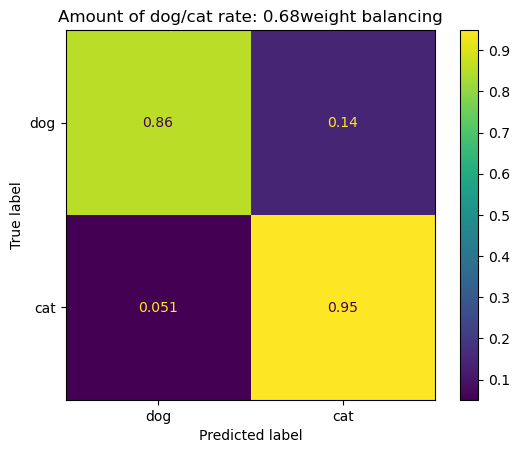

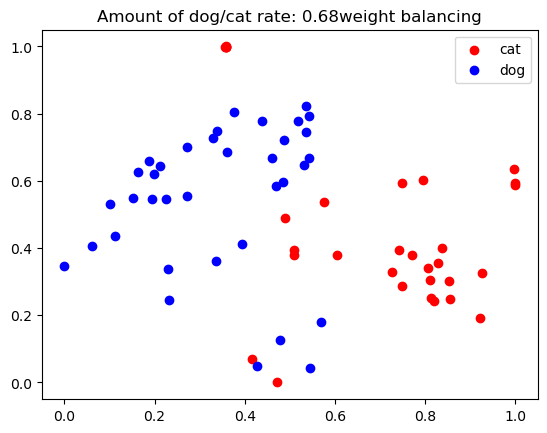

C:\Users\Stefano\AppData\Local\Temp\ipykernel_15832\235712720.py:114: RuntimeWarning: invalid value encountered in true_divide
  X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


125
125
Epoch 1/50
8/8 [==============================] - 12s 876ms/step - loss: 1.3198 - accuracy: 0.6720 - val_loss: 0.7435 - val_accuracy: 0.8955
Epoch 2/50
8/8 [==============================] - 3s 429ms/step - loss: 0.4366 - accuracy: 0.8600 - val_loss: 0.7845 - val_accuracy: 0.8507
Epoch 3/50
8/8 [==============================] - 4s 474ms/step - loss: 0.2603 - accuracy: 0.9280 - val_loss: 0.8863 - val_accuracy: 0.8806
Epoch 4/50
8/8 [==============================] - 4s 485ms/step - loss: 0.1468 - accuracy: 0.9480 - val_loss: 0.8722 - val_accuracy: 0.8657
Epoch 5/50
8/8 [==============================] - 4s 487ms/step - loss: 0.1243 - accuracy: 0.9440 - val_loss: 1.3041 - val_accuracy: 0.8060
Epoch 6/50
8/8 [==============================] - 4s 484ms/step - loss: 0.1212 - accuracy: 0.9600 - val_loss: 0.9814 - val_accuracy: 0.8657
Epoch 7/50
8/8 [==============================] - 4s 545ms/step - loss: 0.1759 - accuracy: 0.9440 - val_loss: 0.7731 - val_accuracy: 0.9104
Epoch 8/50


C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The Labels
[1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
The tx
[0.54168296 0.633892   0.88370323 1.         0.4762351  0.16039668
 0.29298723 0.44699147 0.10912548 0.13647237 0.92976    0.06043073
 0.57626474 0.8297977  0.38635606 0.41564575 0.34668806 0.28302813
 0.73016256 0.8156551  0.5688387  0.53758204 0.5913821  0.57341665
 0.47150114 0.7532853  0.6667298  0.6725648  0.9167669  0.33285853
 0.         0.7859522  0.44882038 0.97984713 0.7551651  0.38700566
 0.26781845 0.6614798  0.67165285 0.48744044 0.3921912  0.6658542
 0.301262   0.66682583 0.52927476 0.3251944  0.28077635 0.07629986
 0.21836777 0.10698421 0.17718036 0.14744797 0.26459444 0.3298754
 0.29984993 0.37697318 0.21576269 0.7515456  0.13383202 0.22409414
 0.3604381  0.3914622  0.13079076 0.46852905 0.5905844  0.64327854
 0.7348149 ]
The indices
[5, 8, 9, 11, 23, 31, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,

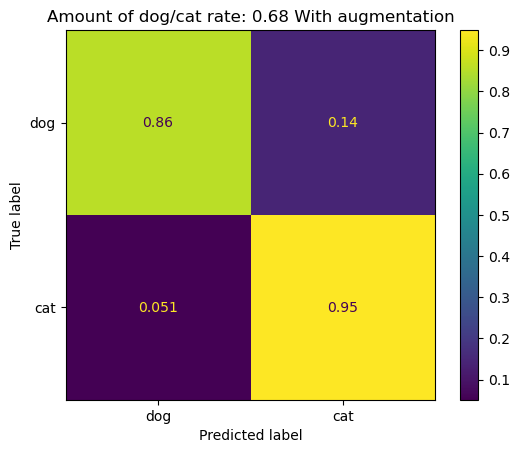

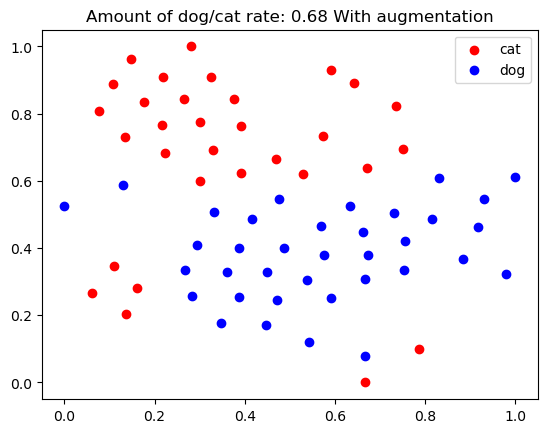

C:\Users\Stefano\AppData\Local\Temp\ipykernel_15832\235712720.py:25: RuntimeWarning: invalid value encountered in true_divide
  X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
C:\Users\Stefano\AppData\Local\Temp\ipykernel_15832\235712720.py:40: RuntimeWarning: invalid value encountered in true_divide
  X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


Epoch 1/5
6/6 [==============================] - 11s 972ms/step - loss: 1.7540 - accuracy: 0.6223 - val_loss: 1.1143 - val_accuracy: 0.7910
Epoch 2/5
6/6 [==============================] - 3s 514ms/step - loss: 0.7111 - accuracy: 0.8777 - val_loss: 0.5642 - val_accuracy: 0.8806
Epoch 3/5
6/6 [==============================] - 3s 511ms/step - loss: 0.4461 - accuracy: 0.9149 - val_loss: 1.0029 - val_accuracy: 0.8806
Epoch 4/5
6/6 [==============================] - 3s 536ms/step - loss: 0.1761 - accuracy: 0.9362 - val_loss: 0.9190 - val_accuracy: 0.8060
Epoch 5/5
3/3 [==============================] - 4s 197ms/step
              precision    recall  f1-score   support

         dog     1.0000    0.7500    0.8571        28
         cat     0.8478    1.0000    0.9176        39

    accuracy                         0.8955        67
   macro avg     0.9239    0.8750    0.8874        67
weighted avg     0.9114    0.8955    0.8924        67



C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The Labels
[1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1]
The tx
[0.1766358  0.54687744 0.3252929  0.22433992 0.48900113 0.94212186
 0.48570418 0.58555764 0.97745216 0.8980307  0.3342824  0.91528076
 0.6925859  0.41741467 0.50534195 0.5610662  0.6517202  0.7476057
 0.46855465 0.4225913  0.8022224  0.6010726  0.5326969  1.
 0.6599718  0.530334   0.61113083 0.61745006 0.3461622  0.6654704
 0.0168174  0.         0.5808775  0.01534799 0.5197788  0.6341742
 0.7323067  0.44565633 0.37142903 0.6750751  0.522616   0.08936126
 0.4480687  0.09771992 0.43404132 0.22680128 0.19168311 0.31512108
 0.36493948 0.19305113 0.25242707 0.24558525 0.27562284 0.44225627
 0.30626008 0.15197389 0.0989005  0.11846978 0.1468811  0.36308244
 0.73007166 0.33705306 0.20490015 0.58118343 0.1039689  0.16024303
 0.28487006]
The indices
[5, 8, 9, 11, 23, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 61, 63, 

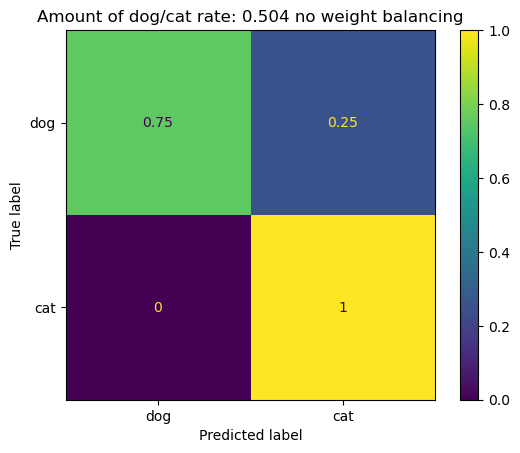

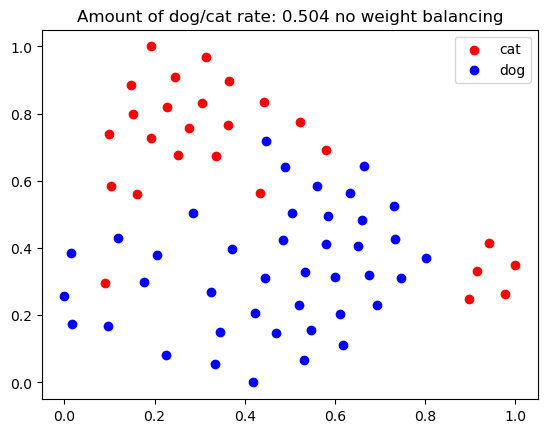

Epoch 1/50
6/6 [==============================] - 11s 1s/step - loss: 2.4316 - accuracy: 0.5585 - val_loss: 2.4123 - val_accuracy: 0.8209
Epoch 2/50
6/6 [==============================] - 3s 516ms/step - loss: 1.6957 - accuracy: 0.7394 - val_loss: 1.7392 - val_accuracy: 0.7164
Epoch 3/50
6/6 [==============================] - 3s 517ms/step - loss: 0.6840 - accuracy: 0.8298 - val_loss: 0.6191 - val_accuracy: 0.8955
Epoch 4/50
6/6 [==============================] - 3s 463ms/step - loss: 0.3504 - accuracy: 0.8936 - val_loss: 0.4791 - val_accuracy: 0.9254
Epoch 5/50
6/6 [==============================] - 3s 458ms/step - loss: 0.2065 - accuracy: 0.9362 - val_loss: 0.5716 - val_accuracy: 0.8358
Epoch 6/50
6/6 [==============================] - 3s 472ms/step - loss: 0.1270 - accuracy: 0.8936 - val_loss: 0.5973 - val_accuracy: 0.9104
Epoch 7/50
6/6 [==============================] - 3s 540ms/step - loss: 0.1057 - accuracy: 0.9787 - val_loss: 0.5872 - val_accuracy: 0.8657
Epoch 8/50
6/6 [======

C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The Labels
[1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
The tx
[0.06435509 0.24372719 0.08152422 0.07956266 0.3959251  0.3001835
 0.19084518 0.09736092 0.41243073 0.35216504 0.13827592 0.3428005
 0.1359469  0.23864539 0.25110364 0.33878928 0.07624808 0.17181417
 0.0783632  0.04362683 0.11034407 0.24118127 0.18362442 0.3522928
 0.16141649 0.12713182 0.14296325 0.18501343 0.15328927 0.3319933
 0.06304427 1.         0.26187554 0.21142387 0.04386387 0.28394148
 0.3030058  0.19703883 0.43561706 0.21556011 0.4951546  0.46802643
 0.49424192 0.10991205 0.43146682 0.6399577  0.78013796 0.7671018
 0.738197   0.70655704 0.6768173  0.72001994 0.6754142  0.567374
 0.61764157 0.61530596 0.5636495  0.48522556 0.55535275 0.6559219
 0.2202838  0.5908522  0.         0.40068743 0.63400483 0.5928623
 0.64295155]
The indices
[4, 5, 8, 9, 11, 23, 30, 31, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,

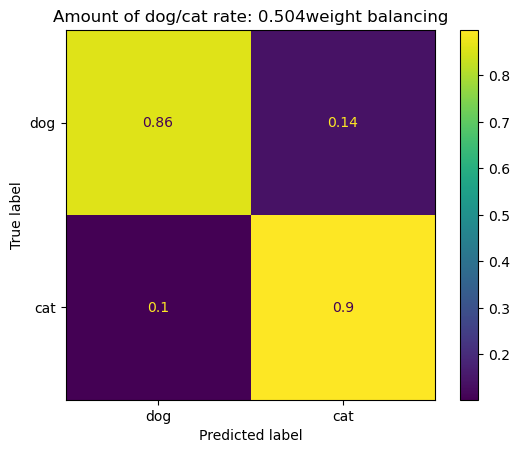

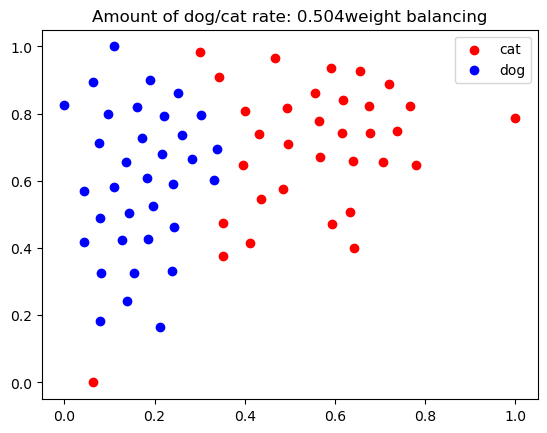

C:\Users\Stefano\AppData\Local\Temp\ipykernel_15832\235712720.py:114: RuntimeWarning: invalid value encountered in true_divide
  X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


124
125
Epoch 1/50
8/8 [==============================] - 12s 815ms/step - loss: 1.7060 - accuracy: 0.6627 - val_loss: 0.8350 - val_accuracy: 0.8358
Epoch 2/50
8/8 [==============================] - 4s 484ms/step - loss: 0.3571 - accuracy: 0.8996 - val_loss: 0.8765 - val_accuracy: 0.8507
Epoch 3/50
8/8 [==============================] - 4s 471ms/step - loss: 0.2831 - accuracy: 0.9277 - val_loss: 0.9020 - val_accuracy: 0.8358
Epoch 4/50
8/8 [==============================] - 4s 466ms/step - loss: 0.1169 - accuracy: 0.9679 - val_loss: 0.9136 - val_accuracy: 0.8358
Epoch 5/50
8/8 [==============================] - 3s 433ms/step - loss: 0.0515 - accuracy: 0.9839 - val_loss: 1.0345 - val_accuracy: 0.8507
Epoch 6/50
8/8 [==============================] - 4s 511ms/step - loss: 0.0362 - accuracy: 0.9839 - val_loss: 0.9265 - val_accuracy: 0.8806
Epoch 7/50
8/8 [==============================] - 4s 489ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.9226 - val_accuracy: 0.8657
Epoch 8/50


C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The Labels
[1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
The tx
[0.30983508 0.6043954  0.31095177 0.471379   0.43781963 0.9754287
 0.6032185  0.6894024  0.9378398  1.         0.4915457  0.92335904
 0.73613995 0.4053661  0.71918297 0.59095615 0.76582354 0.84170496
 0.7497596  0.7185324  0.68255466 0.80550706 0.8261937  0.22067076
 0.659589   0.6685841  0.6555243  0.6031892  0.48361912 0.5361378
 0.32231966 0.30587298 0.7581321  0.3895674  0.63885885 0.59686255
 0.8047693  0.7473763  0.3860066  0.71341634 0.4175007  0.21965289
 0.36815497 0.22813644 0.48499903 0.23054191 0.07237712 0.17545272
 0.1499033  0.08347464 0.20594004 0.09070651 0.16133425 0.35453743
 0.2724781  0.1738861  0.23535538 0.33456174 0.24191576 0.3233212
 0.6721611  0.29693338 0.40598658 0.4774042  0.         0.03997786
 0.08999062]
The indices
[2, 4, 5, 8, 9, 11, 23, 30, 31, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53

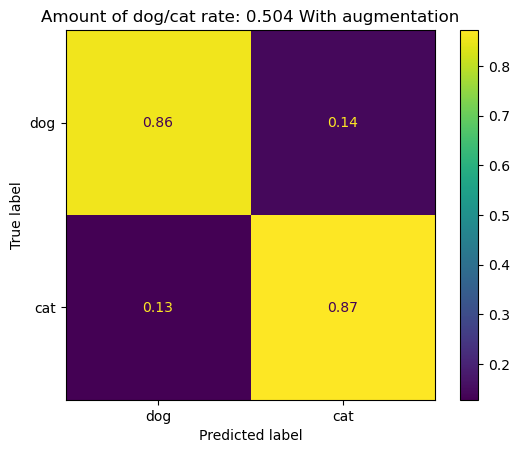

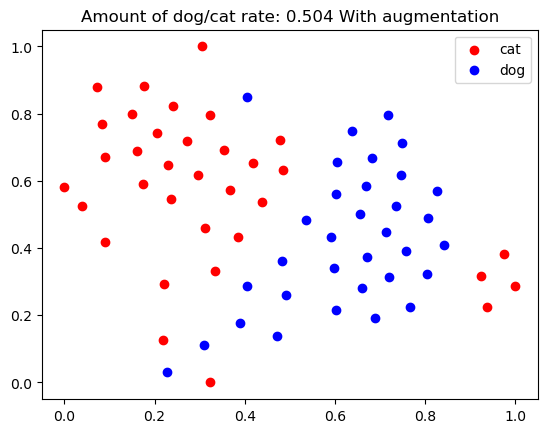

C:\Users\Stefano\AppData\Local\Temp\ipykernel_15832\235712720.py:25: RuntimeWarning: invalid value encountered in true_divide
  X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
C:\Users\Stefano\AppData\Local\Temp\ipykernel_15832\235712720.py:40: RuntimeWarning: invalid value encountered in true_divide
  X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


Epoch 1/5
5/5 [==============================] - 12s 1s/step - loss: 3.7295 - accuracy: 0.7484 - val_loss: 2.3309 - val_accuracy: 0.5373
Epoch 2/5
5/5 [==============================] - 3s 591ms/step - loss: 1.4420 - accuracy: 0.7032 - val_loss: 3.4622 - val_accuracy: 0.6418
Epoch 3/5
5/5 [==============================] - 3s 553ms/step - loss: 0.5680 - accuracy: 0.8839 - val_loss: 1.3518 - val_accuracy: 0.7164
Epoch 4/5
5/5 [==============================] - 3s 634ms/step - loss: 0.2428 - accuracy: 0.9226 - val_loss: 2.8064 - val_accuracy: 0.6567
Epoch 5/5
3/3 [==============================] - 3s 227ms/step
              precision    recall  f1-score   support

         dog     0.8000    0.2857    0.4211        28
         cat     0.6491    0.9487    0.7708        39

    accuracy                         0.6716        67
   macro avg     0.7246    0.6172    0.5959        67
weighted avg     0.7122    0.6716    0.6247        67



C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The Labels
[1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0]
The tx
[2.9310083e-01 8.0767906e-01 6.4076400e-01 7.5578159e-01 7.0810878e-01
 1.6837167e-04 2.3118076e-01 5.2400881e-01 9.3879782e-02 7.7159092e-02
 1.0000000e+00 7.8532264e-02 5.2982450e-01 9.1043705e-01 2.5286165e-01
 4.2581534e-01 3.8015485e-01 4.4543815e-01 7.4121189e-01 8.0766970e-01
 6.6511333e-01 2.8935346e-01 3.1010863e-01 0.0000000e+00 3.7803134e-01
 9.1115302e-01 9.8443735e-01 9.0757751e-01 7.3278874e-01 5.0417179e-01
 8.8828695e-01 8.3603364e-01 4.5374215e-01 7.1109563e-01 8.1579357e-01
 4.5130444e-01 3.5794744e-01 6.0589117e-01 7.8591806e-01 5.5184770e-01
 7.0137209e-01 9.8605901e-01 6.2964952e-01 9.1049850e-01 4.0425539e-01
 6.7303616e-01 2.6402292e-01 7.3564529e-01 6.5352565e-01 6.6404545e-01
 5.6139511e-01 4.0114352e-01 4.9247384e-01 5.9718072e-01 4.7962174e-01
 5.5464482e-01 5.6350571e-01 8.6637986e-01 6.2269658e-01 5.45653

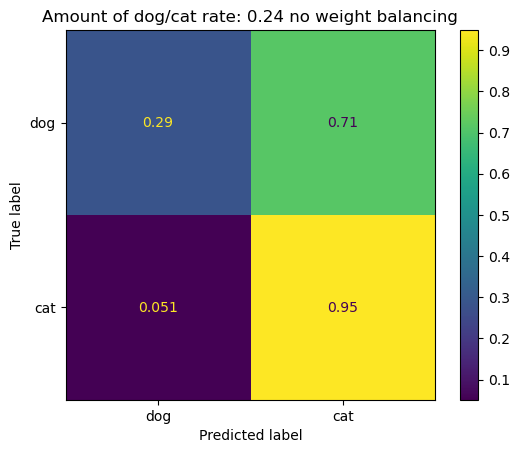

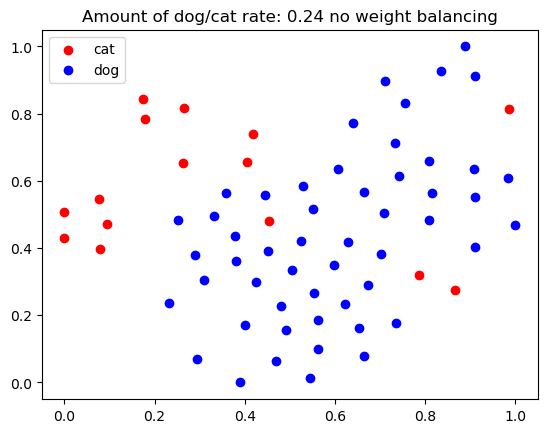

Epoch 1/50
5/5 [==============================] - 13s 2s/step - loss: 1.7725 - accuracy: 0.4710 - val_loss: 2.0468 - val_accuracy: 0.5821
Epoch 2/50
5/5 [==============================] - 3s 526ms/step - loss: 0.8532 - accuracy: 0.4903 - val_loss: 4.8147 - val_accuracy: 0.6269
Epoch 3/50
5/5 [==============================] - 3s 609ms/step - loss: 2.8821 - accuracy: 0.5806 - val_loss: 11.4927 - val_accuracy: 0.4925
Epoch 4/50
5/5 [==============================] - 3s 603ms/step - loss: 1.8796 - accuracy: 0.6000 - val_loss: 5.4251 - val_accuracy: 0.6866
Epoch 5/50
5/5 [==============================] - 3s 680ms/step - loss: 1.1931 - accuracy: 0.8645 - val_loss: 3.7982 - val_accuracy: 0.6418
Epoch 6/50
5/5 [==============================] - 3s 631ms/step - loss: 1.0074 - accuracy: 0.5548 - val_loss: 1.4317 - val_accuracy: 0.6866
Epoch 7/50
5/5 [==============================] - 3s 573ms/step - loss: 0.1712 - accuracy: 0.9548 - val_loss: 1.6592 - val_accuracy: 0.7015
Epoch 8/50
5/5 [=====

C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The Labels
[1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
The tx
[0.5668009  0.50981414 0.64128983 0.9727149  0.46872324 0.12902264
 0.63156515 0.33729097 0.12990786 0.28514493 0.45074168 0.20857719
 0.33930033 0.7473251  0.24371392 0.3972055  0.43047065 0.32091784
 0.6012694  0.6397425  0.50088716 0.43716848 0.51828    0.21172756
 0.3300583  0.71010035 0.73840743 0.69165826 0.6175816  0.33896998
 0.9742059  1.         0.18051256 0.88925755 0.5594871  0.2720669
 0.25003347 0.5949467  0.6079673  0.39682606 0.02436852 0.8210566
 0.1863667  0.90953296 0.08526537 0.538258   0.7147668  0.31152478
 0.23580413 0.39411795 0.39520437 0.3559569  0.4076216  0.1400274
 0.3377756  0.4833088  0.44887537 0.7122312  0.49000713 0.2608989
 0.25451133 0.29918823 0.5085021  0.         0.78687614 0.7581536
 0.6735083 ]
The indices
[5, 8, 9, 11, 23, 40, 41, 44, 63, 64, 65, 66]
The tx
[0.5668009  0.50981414 0.64128983 0

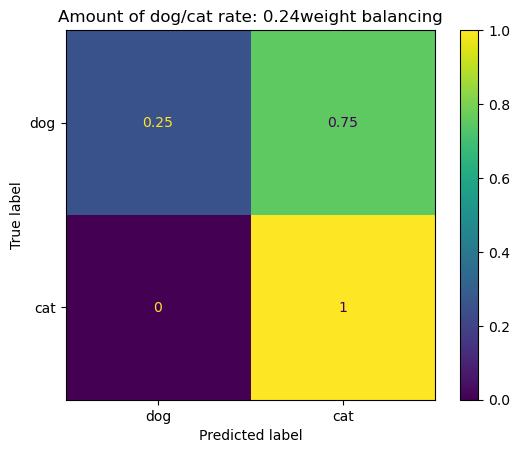

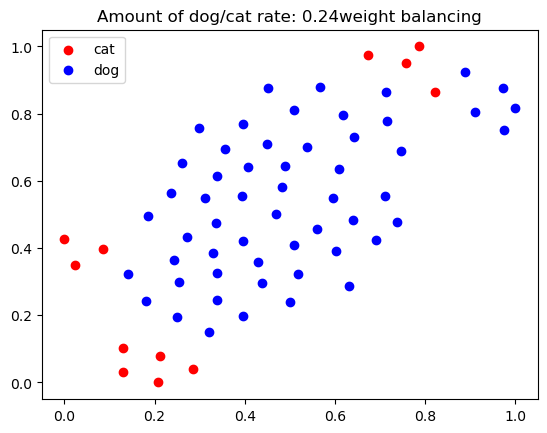

C:\Users\Stefano\AppData\Local\Temp\ipykernel_15832\235712720.py:114: RuntimeWarning: invalid value encountered in true_divide
  X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))


124
125
Epoch 1/50
8/8 [==============================] - 12s 863ms/step - loss: 1.7027 - accuracy: 0.6345 - val_loss: 1.2792 - val_accuracy: 0.8358
Epoch 2/50
8/8 [==============================] - 4s 478ms/step - loss: 0.6949 - accuracy: 0.8795 - val_loss: 0.6506 - val_accuracy: 0.8806
Epoch 3/50
8/8 [==============================] - 4s 479ms/step - loss: 0.2737 - accuracy: 0.9317 - val_loss: 0.5617 - val_accuracy: 0.8358
Epoch 4/50
8/8 [==============================] - 4s 537ms/step - loss: 0.0972 - accuracy: 0.9639 - val_loss: 0.6860 - val_accuracy: 0.8955
Epoch 5/50
8/8 [==============================] - 4s 485ms/step - loss: 0.0391 - accuracy: 0.9920 - val_loss: 0.8051 - val_accuracy: 0.8657
Epoch 6/50
8/8 [==============================] - 4s 503ms/step - loss: 0.0230 - accuracy: 0.9920 - val_loss: 0.8186 - val_accuracy: 0.8806
Epoch 7/50
8/8 [==============================] - 4s 494ms/step - loss: 0.0171 - accuracy: 0.9960 - val_loss: 0.9010 - val_accuracy: 0.8507
Epoch 8/50


C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


The Labels
[1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
The tx
[0.88534933 0.34030232 0.52889997 0.5412756  0.48411754 0.08898544
 0.35511872 0.40320376 0.         0.05428705 0.4695468  0.01849534
 0.2629655  0.45999414 0.37051052 0.4458225  0.30819458 0.17831282
 0.19773972 0.21456242 0.27120316 0.20011435 0.1620446  0.0767986
 0.31964567 0.38610998 0.34579182 0.3086199  0.39521125 0.4136453
 0.82806224 0.7973692  0.2547804  0.7533981  0.29278666 0.4405502
 0.17424934 0.22698984 0.60364985 0.23870592 0.5888415  0.8373927
 0.6521662  0.55340356 0.53611773 0.6957551  0.8474516  0.73450685
 0.79690963 0.74552375 0.8158614  0.8768631  0.70662624 0.61338836
 0.7563624  0.76331115 0.87530655 0.6698545  0.8213233  0.62978405
 0.3054118  0.6194667  0.5263769  0.5340455  1.         0.98795754
 0.98271924]
The indices
[5, 8, 9, 11, 23, 31, 33, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 5

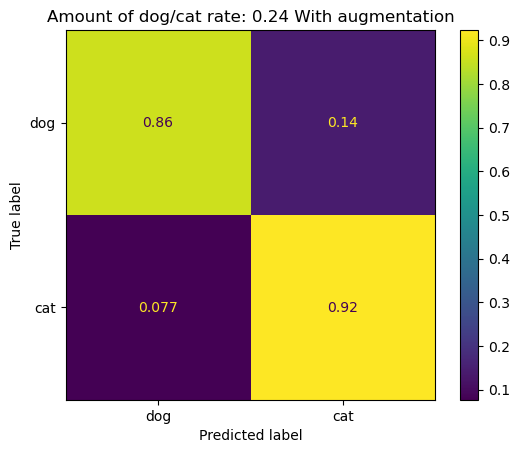

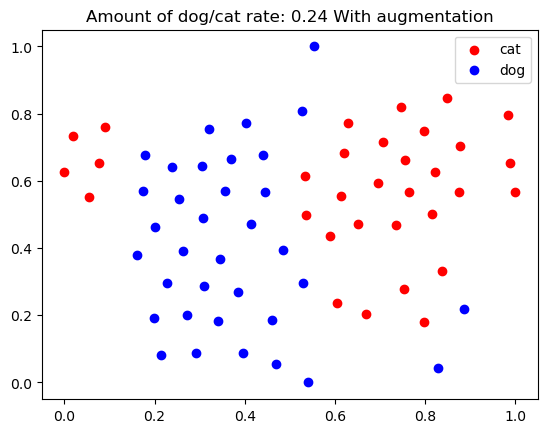

In [101]:
Amount_of_dogs = [85,63,30]
for dog_amount in Amount_of_dogs:
    experiment_string = ''
    experiment_string = experiment_string + "Amount of dog/cat rate: " + str(dog_amount/125)
    amount_of_dogs = 0 
    train=[]
    train_labels=[]
    imbalance = 0
    #Data gathering
    for path in train_paths:
        label=path.split('\\')[-2]
        if label == "dog":
            imbalance = imbalance - 1
            amount_of_dogs = amount_of_dogs +1
        elif label == "cat":
            imbalance = imbalance + 1
        if amount_of_dogs > dog_amount:
            break
        y, sr = librosa.load(path)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        img=log_mel_spectrogram
        img=cv2.resize(np.array(img),dsize=(128,128))
        X=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        train+=[X*255]
        train_labels+=[normal_mapping[label]]

    test=[]
    test_labels=[]
    #data gathering
    for path in test_paths:
        label=path.split('\\')[-2]
        y, sr = librosa.load(path)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        img=log_mel_spectrogram
        img=cv2.resize(np.array(img),dsize=(128,128))
        X=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        test+=[X*255]
        test_labels+=[normal_mapping[fix_mapping[label]]]
    
    trainX_no_augment = np.array(train)
    testX_no_augment = np.array(test)
    train_labels_no_augment = np.array(train_labels)
    test_labels_no_augment = np.array(test_labels)
    train_labels_no_augment = to_categorical(train_labels)
    test_labels_no_augment = to_categorical(test_labels)
    
    experiment_basis = experiment_string + " no weight balancing"
    model.load_weights('model.h5')

    his=model.fit(x= trainX_no_augment, y = train_labels_no_augment,
                  validation_data=(testX_no_augment,test_labels_no_augment),epochs=5)
    y_pred = model.predict(testX_no_augment)
    y_pred2 = np.argmax(y_pred,axis=1)
    ground = np.argmax(test_labels_no_augment,axis=1)
    print(classification_report(ground,y_pred2,target_names=Name,digits=4))

    cm = confusion_matrix(ground, y_pred2, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["dog" , "cat"]).plot()
    disp.ax_.set_title(experiment_basis)
    
    model.save('modelentire.h5')
    model = load_model("modelentire.h5")
    TSNE_visualization(model, testX_no_augment, experiment_basis)
    model.load_weights('model.h5')
    
    

    his=model.fit(x= trainX_no_augment, y = train_labels_no_augment,
                  validation_data=(testX_no_augment,test_labels_no_augment),epochs=50,  class_weight= { 0 : 125/dog_amount , 1 : dog_amount/125 })
    y_pred = model.predict(testX_no_augment)
    y_pred2 = np.argmax(y_pred,axis=1)
    ground = np.argmax(test_labels_no_augment,axis=1)
    
    
    experiment_weight = experiment_string + "weight balancing"
    
    
    print(classification_report(ground,y_pred2,target_names=Name,digits=4))

    cm = confusion_matrix(ground, y_pred2, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["dog" , "cat"]).plot()
    disp.ax_.set_title(experiment_weight)
    model.save('modelentire.h5')
    model = load_model("modelentire.h5")
    TSNE_visualization(model, testX_no_augment , experiment_weight)
    model.load_weights('model.h5')
    


    augment = Compose([
        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.01, p=0.5),
        TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
        PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
        Shift(min_fraction=-0.25, max_fraction=0.25, p=0.5),
    ])
    # data augmentation
    while imbalance != 0:
        for path in train_paths:
            label=path.split('\\')[-2]
            if imbalance == 0:
                break
            elif label == "dog":
                y, sr = librosa.load(path)
                y = augment(samples=y, sample_rate=sr)
                mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
                img=log_mel_spectrogram
                img=cv2.resize(np.array(img),dsize=(128,128))
                X=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
                train+=[X*255]
                train_labels+=[normal_mapping[label]]
                imbalance = imbalance - 1


    trainX = np.array(train)
    testX = np.array(test)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    count_dog = 0
    count_cat = 0

    for label in train_labels:
        if label[1] == 1:
            count_cat = count_cat + 1
        elif label[1] == 0:
            count_dog = count_dog + 1
    print(count_dog)
    print(count_cat)
    experiment_aug = experiment_string + " With augmentation"
    model.load_weights('model.h5')
    his=model.fit(x= trainX, y = train_labels,
                  validation_data=(testX,test_labels),epochs=50)

    y_pred = model.predict(testX)
    y_pred2 = np.argmax(y_pred,axis=1)
    ground = np.argmax(test_labels,axis=1)
    print(classification_report(ground,y_pred2,target_names=Name,digits=4))

    cm = confusion_matrix(ground, y_pred2, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["dog" , "cat"]).plot()
    disp.ax_.set_title(experiment_aug)
    model.save('modelentire.h5')
    model = load_model("modelentire.h5" )
    TSNE_visualization(model, testX, experiment_aug)
    model.load_weights('model.h5')


In [21]:
def shrink_vector(vector, max_val):
    replacement = []
    for i in vector:
        if i > max_val:
            break
        else:
            replacement.append(i)
    return replacement
    

In [103]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [104]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 2

model = Sequential([
    InputLayer(input_shape = (64,64,3)),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    GlobalMaxPooling2D(),
    Flatten(),
    Dense(512,activation='relu'),
    Dropout(0.2),
    Dense(1024,activation='relu'),
    Dropout(0.2),
    Dense(1,activation='sigmoid')

])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.save_weights("modelimage.h5")

In [19]:
def TSNE_visualization(model, testX, title):
    

    model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    y_pred = []
    for p, _ in testX.take(1): # Takes 1 batch
        features = model2(p)         # Predict 1 batch
        preds = model.predict(p)

        for prediction in preds:
            if prediction[0] > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
    
    labels = y_pred

    tsne = TSNE(n_components=2).fit_transform(features)

    def scale_to_01_range(x):

        value_range = (np.max(x) - np.min(x))
        starts_from_zero = x - np.min(x)
        return starts_from_zero / value_range

    tx = tsne[:, 0]
    ty = tsne[:, 1]

    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    colors = ['red', 'blue']
    classes = ["Chihuaha" , "Cookie"]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for idx, c in enumerate(colors):
        indices = [i for i, l in enumerate(labels) if idx == l]
        indices = shrink_vector(indices, len(tx) - 1)
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        ax.scatter(current_tx, current_ty, c=c, label=classes[idx])

    ax.legend(loc='best')
    plt.title(title)
    plt.show()

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
['chihuahua', 'muffin']
[2559, 2174]
Epoch 1/50
10/10 [==============================] - 20s 2s/step - loss: 1.8712 - accuracy: 0.5269 - val_loss: 7.3815 - val_accuracy: 0.5405
Epoch 2/50
10/10 [==============================] - 18s 2s/step - loss: 0.6192 - accuracy: 0.6628 - val_loss: 11.5571 - val_accuracy: 0.5405
Epoch 3/50
10/10 [==============================] - 18s 2s/step - loss: 0.4369 - accuracy: 0.8098 - val_loss: 10.5164 - val_accuracy: 0.5405
Epoch 4/50
10/10 [==============================] - 18s 2s/step - loss: 0.3557 - accuracy: 0.8555 - val_loss: 2.2480 - val_accuracy: 0.5405
Epoch 5/50
10/10 [==============================] - 17s 2s/step - loss: 0.3048 - accuracy: 0.8840 - val_loss: 6.1894 - val_accuracy: 0.5405
Epoch 6/50
10/10 [==============================] - 18s 2s/step - loss: 0.2658 - accuracy: 0.8984 - val_loss: 2.5631 - val_accuracy: 0.5414
Epoch 7/50
10/10 [=====================

C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


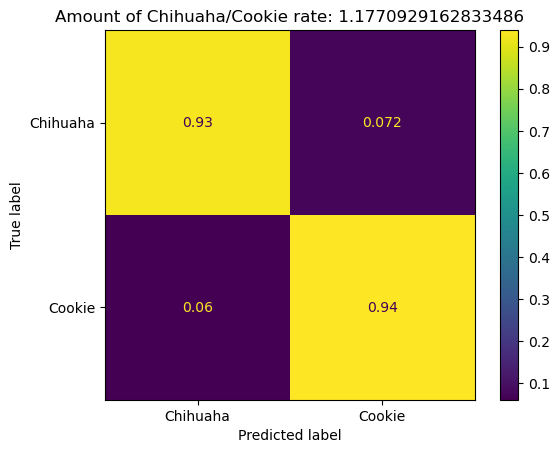

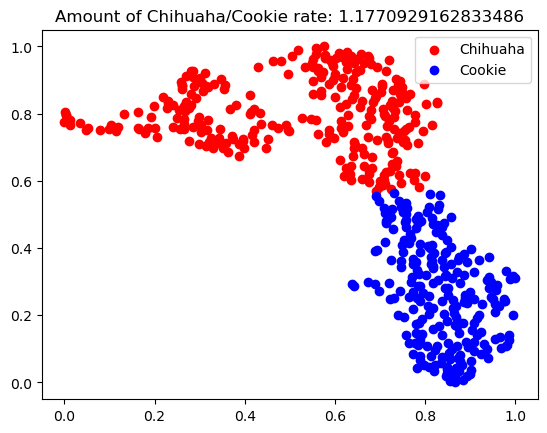

Found 3398 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
['chiahuaha', 'muffin']
[1224, 2174]
Epoch 1/50
7/7 [==============================] - 15s 2s/step - loss: 2.0347 - accuracy: 0.5250 - val_loss: 7.1133 - val_accuracy: 0.5405
Epoch 2/50
7/7 [==============================] - 13s 2s/step - loss: 0.5051 - accuracy: 0.7763 - val_loss: 22.5446 - val_accuracy: 0.5405
Epoch 3/50
7/7 [==============================] - 13s 2s/step - loss: 0.3878 - accuracy: 0.8399 - val_loss: 20.8459 - val_accuracy: 0.5405
Epoch 4/50
7/7 [==============================] - 13s 2s/step - loss: 0.3320 - accuracy: 0.8640 - val_loss: 13.3091 - val_accuracy: 0.5405
Epoch 5/50
7/7 [==============================] - 13s 2s/step - loss: 0.2837 - accuracy: 0.8879 - val_loss: 10.8062 - val_accuracy: 0.5405
Epoch 6/50
7/7 [==============================] - 13s 2s/step - loss: 0.2608 - accuracy: 0.9014 - val_loss: 7.2559 - val_accuracy: 0.5405
Epoch 7/50
7/7 [==============================] -

C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


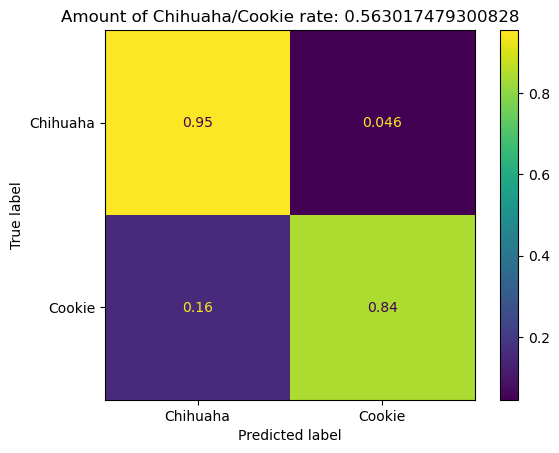

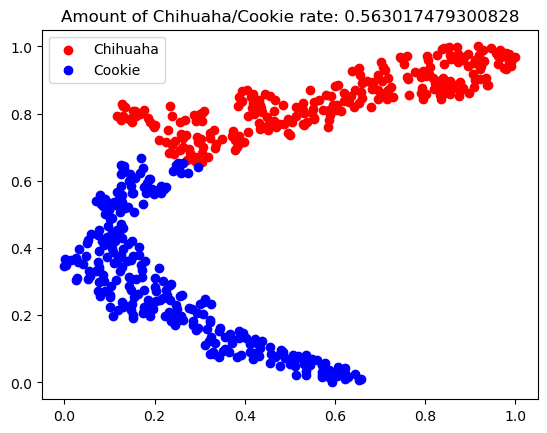

Weight balancing 1/2
Epoch 1/50
7/7 [==============================] - 16s 2s/step - loss: 1.0615 - accuracy: 0.6198 - val_loss: 1.9303 - val_accuracy: 0.5405
Epoch 2/50
7/7 [==============================] - 14s 2s/step - loss: 0.4040 - accuracy: 0.7254 - val_loss: 3.6233 - val_accuracy: 0.5405
Epoch 3/50
7/7 [==============================] - 13s 2s/step - loss: 0.2625 - accuracy: 0.8373 - val_loss: 10.7988 - val_accuracy: 0.5405
Epoch 4/50
7/7 [==============================] - 13s 2s/step - loss: 0.2164 - accuracy: 0.8558 - val_loss: 5.9866 - val_accuracy: 0.5405
Epoch 5/50
7/7 [==============================] - 14s 2s/step - loss: 0.1880 - accuracy: 0.8829 - val_loss: 6.2784 - val_accuracy: 0.5405
Epoch 6/50
7/7 [==============================] - 14s 2s/step - loss: 0.1739 - accuracy: 0.9005 - val_loss: 4.3665 - val_accuracy: 0.5405
Epoch 7/50
7/7 [==============================] - 14s 2s/step - loss: 0.1582 - accuracy: 0.9058 - val_loss: 4.5311 - val_accuracy: 0.5405
Epoch 8/50
7

C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


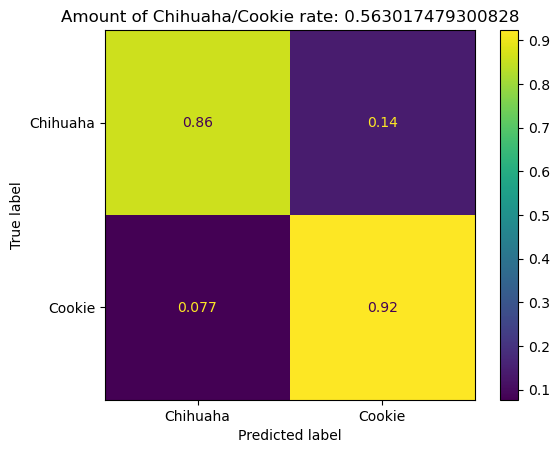

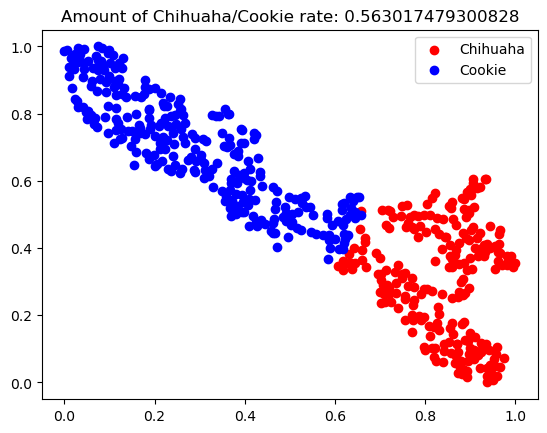

Found 2694 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
['chihuaha', 'muffin']
[520, 2174]
Epoch 1/50
6/6 [==============================] - 11s 2s/step - loss: 1.3051 - accuracy: 0.7725 - val_loss: 0.7145 - val_accuracy: 0.5304
Epoch 2/50
6/6 [==============================] - 11s 2s/step - loss: 0.3749 - accuracy: 0.8378 - val_loss: 3.0287 - val_accuracy: 0.5397
Epoch 3/50
6/6 [==============================] - 10s 2s/step - loss: 0.2926 - accuracy: 0.8890 - val_loss: 4.4203 - val_accuracy: 0.5405
Epoch 4/50
6/6 [==============================] - 10s 2s/step - loss: 0.2504 - accuracy: 0.8990 - val_loss: 7.0453 - val_accuracy: 0.5405
Epoch 5/50
6/6 [==============================] - 11s 2s/step - loss: 0.2197 - accuracy: 0.9113 - val_loss: 2.6220 - val_accuracy: 0.5405
Epoch 6/50
6/6 [==============================] - 11s 2s/step - loss: 0.1923 - accuracy: 0.9258 - val_loss: 3.7345 - val_accuracy: 0.5405
Epoch 7/50
6/6 [==============================] - 10s 2

C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


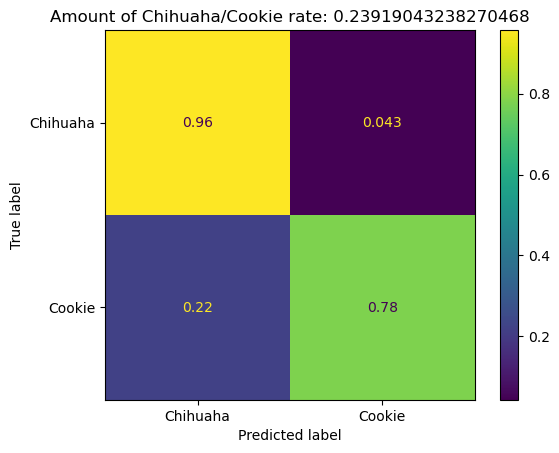

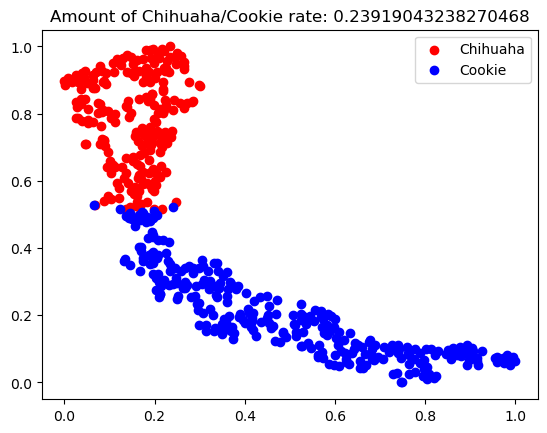

Weight balancing 1/4
Epoch 1/50
6/6 [==============================] - 12s 2s/step - loss: 3.6062e-05 - accuracy: 1.0000 - val_loss: 1.1061 - val_accuracy: 0.8573
Epoch 2/50
6/6 [==============================] - 12s 2s/step - loss: 1.9692e-05 - accuracy: 1.0000 - val_loss: 1.1152 - val_accuracy: 0.8573
Epoch 3/50
6/6 [==============================] - 12s 2s/step - loss: 1.8579e-05 - accuracy: 1.0000 - val_loss: 1.1259 - val_accuracy: 0.8564
Epoch 4/50
6/6 [==============================] - 11s 2s/step - loss: 1.7170e-05 - accuracy: 1.0000 - val_loss: 1.1382 - val_accuracy: 0.8556
Epoch 5/50
6/6 [==============================] - 12s 2s/step - loss: 1.6862e-05 - accuracy: 1.0000 - val_loss: 1.1518 - val_accuracy: 0.8556
Epoch 6/50
6/6 [==============================] - 11s 2s/step - loss: 1.7430e-05 - accuracy: 1.0000 - val_loss: 1.1650 - val_accuracy: 0.8539
Epoch 7/50
6/6 [==============================] - 11s 2s/step - loss: 1.6955e-05 - accuracy: 1.0000 - val_loss: 1.1779 - val_ac

C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


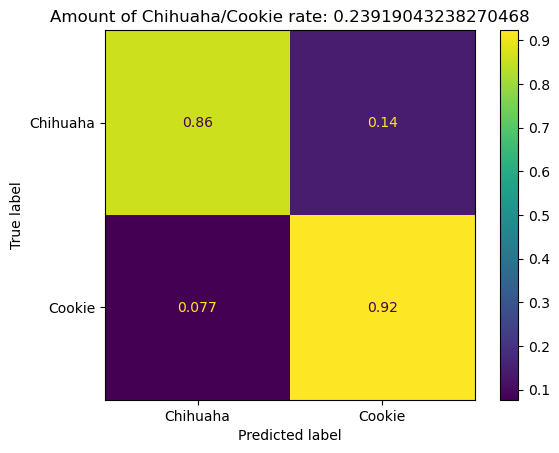

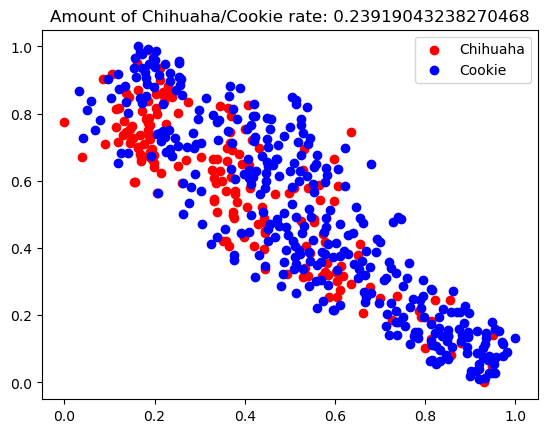

Found 3918 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
['chiahuaha', 'muffin']
[1744, 2174]
Epoch 1/50
8/8 [==============================] - 16s 2s/step - loss: 1.5524 - accuracy: 0.5745 - val_loss: 1.8501 - val_accuracy: 0.5405
Epoch 2/50
8/8 [==============================] - 15s 2s/step - loss: 0.4461 - accuracy: 0.8060 - val_loss: 33.1775 - val_accuracy: 0.5405
Epoch 3/50
8/8 [==============================] - 15s 2s/step - loss: 0.3242 - accuracy: 0.8698 - val_loss: 5.9066 - val_accuracy: 0.5405
Epoch 4/50
8/8 [==============================] - 15s 2s/step - loss: 0.2584 - accuracy: 0.8982 - val_loss: 9.7576 - val_accuracy: 0.5405
Epoch 5/50
8/8 [==============================] - 15s 2s/step - loss: 0.2406 - accuracy: 0.9091 - val_loss: 7.0465 - val_accuracy: 0.5405
Epoch 6/50
8/8 [==============================] - 15s 2s/step - loss: 0.2009 - accuracy: 0.9260 - val_loss: 6.6450 - val_accuracy: 0.5405
Epoch 7/50
8/8 [==============================] - 15

C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


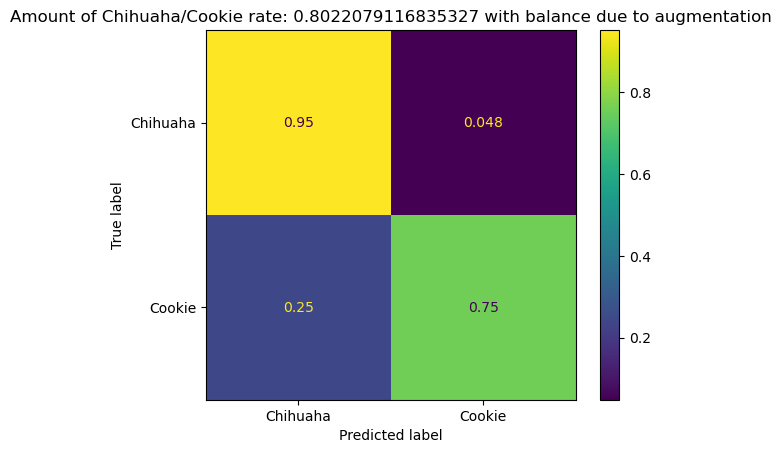

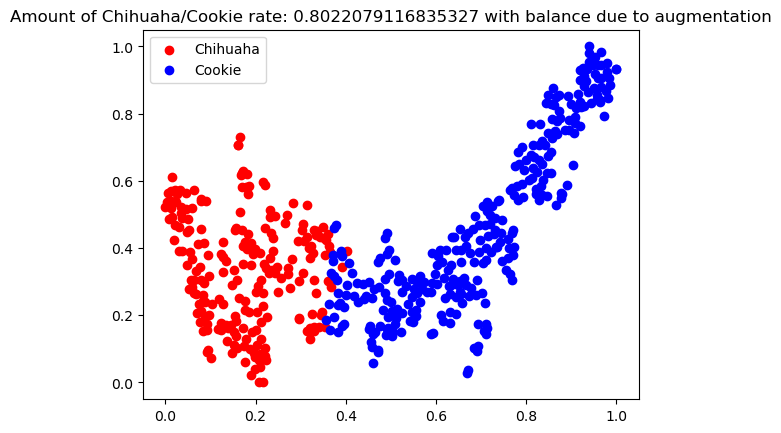

Found 3990 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
['chiahuaha', 'muffin']
[1816, 2174]
Epoch 1/50
8/8 [==============================] - 16s 2s/step - loss: 1.5420 - accuracy: 0.5556 - val_loss: 17.2556 - val_accuracy: 0.5405
Epoch 2/50
8/8 [==============================] - 16s 2s/step - loss: 0.4867 - accuracy: 0.7684 - val_loss: 37.6785 - val_accuracy: 0.5405
Epoch 3/50
8/8 [==============================] - 15s 2s/step - loss: 0.3342 - accuracy: 0.8697 - val_loss: 15.2062 - val_accuracy: 0.5405
Epoch 4/50
8/8 [==============================] - 15s 2s/step - loss: 0.2527 - accuracy: 0.9018 - val_loss: 12.9711 - val_accuracy: 0.5405
Epoch 5/50
8/8 [==============================] - 15s 2s/step - loss: 0.2196 - accuracy: 0.9145 - val_loss: 5.9925 - val_accuracy: 0.5405
Epoch 6/50
8/8 [==============================] - 16s 2s/step - loss: 0.1820 - accuracy: 0.9308 - val_loss: 5.8235 - val_accuracy: 0.5405
Epoch 7/50
8/8 [==============================] -

C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Stefano\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


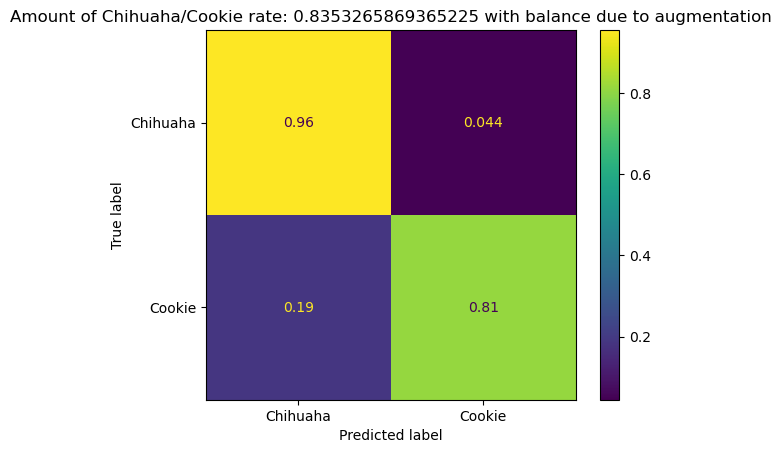

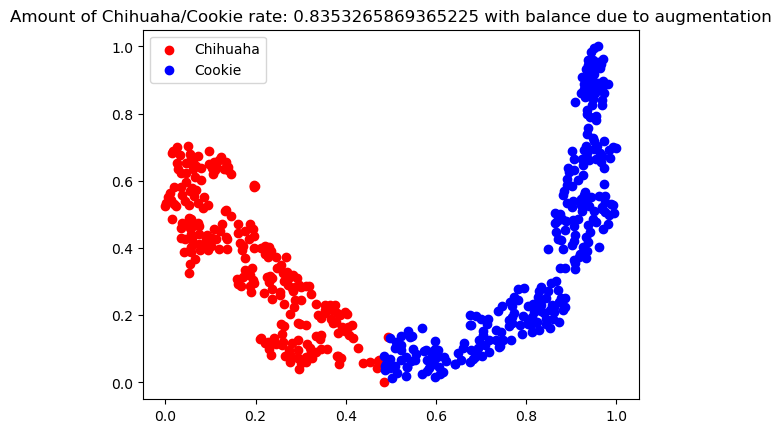

In [106]:
paths_to_test = ['muffinchi/train' ,'muffinchi/train_12' , 'muffinchi/train_14' ,'muffinchi/train_12aug' , 'muffinchi/train_14aug' ]
EPOCHS = 50

for path_to_test in paths_to_test:
    
    experiment_string = ''
    
    
    train_dir = path_to_test
    test_dir = 'muffinchi/test'
    AUTOTUNE = tf.data.AUTOTUNE

    train_set = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=42,
        batch_size=512,
        labels='inferred',
        label_mode='int',
        shuffle=True,
        image_size=(64, 64))

    test_set = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        batch_size=512,
        seed=42,
        labels='inferred',
        label_mode='int',
        shuffle=True,
        image_size=(64, 64))
    
    class_names = train_set.class_names
    class_counts = [0] * len(class_names)
    for images, labels in train_set:
        for label in labels:
            class_counts[label] += 1
    print(class_names)
    print(class_counts)
    
    experiment_string = experiment_string + "Amount of Chihuaha/Cookie rate: " + str(class_counts[0]/class_counts[1])
    if path_to_test == 'muffinchi/train_12aug' or path_to_test == 'muffinchi/train_14aug':
        experiment_string = experiment_string + ' with balance due to augmentation'
    
    
    
    train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 
    test_set= test_set.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)
    normalized_ds = train_set.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    model.load_weights("modelimage.h5")
    history = model.fit(train_set, epochs= EPOCHS,validation_data= test_set, validation_steps= None, shuffle= False)
    

    
    
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # iterate over the dataset
    for image_batch, label_batch in test_set:   # use dataset.unbatch() with repeat
        # append true labels
        y_true.append(label_batch.numpy().tolist())
        # compute predictions
        preds = model.predict(image_batch)

        # append predicted labels
        for prediction in preds:
            if prediction[0] > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
            
    
    y_true = [item for sublist in y_true for item in sublist]


    print(classification_report(y_pred,y_true,digits=4))
    
    
    cm = confusion_matrix(y_pred,y_true, normalize = 'true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["Chihuaha" , "Cookie"]).plot()
    disp.ax_.set_title(experiment_string)
    
    
    model.save('modelentireimage.h5')
    model = load_model("modelentireimage.h5" )
    TSNE_visualization(model, test_set, experiment_string)
    
    
    
    if path_to_test == 'muffinchi/train_12aug' or path_to_test == 'muffinchi/train_14aug':
        continue
    else:
        if path_to_test == 'muffinchi/train_12':
            print("Weight balancing 1/2")
            model.load_weights("modelimage.h5")
            history = model.fit(train_set, epochs= EPOCHS,validation_data= test_set, validation_steps= None, shuffle= False ,  class_weight= { 0 : 1/2 , 1 : 1 })
            cm = confusion_matrix(ground, y_pred2, normalize = 'true')
            disp = ConfusionMatrixDisplay(cm, display_labels=["Chihuaha" , "Cookie"]).plot()
            disp.ax_.set_title(experiment_string)
            model.save('modelentireimage.h5')
            model = load_model("modelentireimage.h5" )
            TSNE_visualization(model, test_set, experiment_string)
            
        elif path_to_test == 'muffinchi/train_14':
            print("Weight balancing 1/4")
            history = model.fit(train_set, epochs= EPOCHS,validation_data= test_set, validation_steps= None, shuffle= False ,  class_weight= { 0 : 1/4 , 1 : 1 })
            model.load_weights("modelimage.h5")
            cm = confusion_matrix(ground, y_pred2, normalize = 'true')
            disp = ConfusionMatrixDisplay(cm, display_labels=["Chihuaha" , "Cookie"]).plot()
            disp.ax_.set_title(experiment_string)
            model.save('modelentireimage.h5')
            model = load_model("modelentireimage.h5" )
            TSNE_visualization(model, test_set, experiment_string)
            


# How does the incorporation of time series analysis techniques enhance the accuracy and forcasting capabilities of regression models for time-dependent data and how do they perform oposed to each other?

In [140]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt #for plotting

x, y, coef = datasets.make_regression(n_samples=1000,#number of samples
                                      n_features=1,#number of features
                                      n_informative=1,#number of useful features 
                                      noise=100000000,#bias and standard deviation of the guassian noise
                                      coef=True,#true coefficient used to generated the data
                                      random_state=0) #set for same data points for each run

# Scale feature x (years of experience) to range 0..20
x = np.interp(x, (x.min(), x.max()), (0, 20))
x = np.sort(x, axis = 0)


# Scale target y (salary) to range 20000..150000 
y = np.interp(y, (y.min(), y.max()), (20000, 150000))
y = np.sort(y, axis = 0)




dataframe_experiment = pd.DataFrame({'X': x.flatten(), 'Y': y}, columns=['X', 'Y'])
dataframe_experiment.head()

X        Y
0 0.00 20000.00
1 0.73 24470.63
2 0.94 29801.38
3 1.06 30727.74
4 1.33 36903.95

In [141]:
train_df, test_df = train_test_split(dataframe_experiment, test_size=0.5, shuffle=False)




X_train = train_df.iloc[:, 0:-1]
y_train = train_df.iloc[:, -1]

X_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
print(predictions)




 62%|██████▏   | 26/42 [00:01<00:00, 20.28it/s]

OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(500, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.


100%|██████████| 42/42 [00:02<00:00, 14.69it/s]

                               Adjusted R-Squared   R-Squared        RMSE  \
Model                                                                       
HuberRegressor                               0.98        0.98     1754.30   
PassiveAggressiveRegressor                   0.98        0.98     1792.46   
Ridge                                        0.97        0.97     1947.02   
LassoLars                                    0.97        0.97     1954.63   
LassoCV                                      0.97        0.97     1980.30   
RidgeCV                                      0.97        0.97     2007.10   
Lasso                                        0.97        0.97     2011.15   
BayesianRidge                                0.97        0.97     2013.54   
RANSACRegressor                              0.97        0.97     2013.81   
TransformedTargetRegressor                   0.97        0.97     2013.81   
LinearRegression                             0.97        0.97     2013.81   

In [142]:
huber = HuberRegressor().fit(X_train, y_train)
huber_pedictions_no_features = huber.predict(X_test)


In [143]:
dataframe_experiment = pd.DataFrame({'X': x.flatten(), 'Y': y}, columns=['X', 'Y'])
dataframe_experiment.head()
train_df, test_df = train_test_split(dataframe_experiment, test_size=0.5, shuffle=False)



train_df['SMA2'] = train_df['Y'].rolling(2).mean()
train_df['SMA4'] = train_df['Y'].rolling(4).mean()
train_df['SMA8'] = train_df['Y'].rolling(8).mean()

train_df['SMA15'] = train_df['Y'].rolling(15).mean()
train_df['SMA30'] = train_df['Y'].rolling(30).mean()



train_df['CMA'] = train_df['Y'].expanding().mean()


train_df['EWMA4'] = train_df['Y'].ewm(4).mean()
train_df['EWMA8'] = train_df['Y'].ewm(8).mean()

train_df['EWMA15'] = train_df['Y'].ewm(15).mean()
train_df['EWMA30'] = train_df['Y'].ewm(30).mean()



test_df['SMA2'] = test_df['Y'].rolling(2).mean()
test_df['SMA4'] = test_df['Y'].rolling(4).mean()
test_df['SMA8'] = test_df['Y'].rolling(8).mean()

test_df['SMA15'] = test_df['Y'].rolling(15).mean()
test_df['SMA30'] = test_df['Y'].rolling(30).mean()



test_df['CMA'] = test_df['Y'].expanding().mean()


test_df['EWMA4'] = test_df['Y'].ewm(4).mean()
test_df['EWMA8'] = test_df['Y'].ewm(8).mean()

test_df['EWMA15'] = test_df['Y'].ewm(15).mean()
test_df['EWMA30'] = test_df['Y'].ewm(30).mean()


backup = train_df['Y']
train_df=train_df.loc[:,train_df.columns!='Y']
train_df['Y']= backup


backup = test_df['Y']
test_df=test_df.loc[:,test_df.columns!='Y']
test_df['Y']= backup

test_df = test_df.fillna(method="bfill")
train_df = train_df.fillna(method="bfill")

X_train = train_df.iloc[:, 0:-1]
y_train = train_df.iloc[:, -1]

X_test = test_df.iloc[:, 0:-1]
y_test = test_df.iloc[:, -1]

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)
huber = HuberRegressor().fit(X_train, y_train)
huber_pedictions_features = huber.predict(X_test)

100%|██████████| 42/42 [00:03<00:00, 12.70it/s]

                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
OrthogonalMatchingPursuitCV                  1.00       1.00     184.46   
LarsCV                                       1.00       1.00     192.81   
LassoCV                                      1.00       1.00     292.79   
OrthogonalMatchingPursuit                    1.00       1.00     322.16   
RANSACRegressor                              1.00       1.00     338.28   
LassoLars                                    1.00       1.00     369.43   
HuberRegressor                               1.00       1.00     512.78   
LassoLarsCV                                  0.99       0.99     923.24   
Ridge                                        0.99       0.99     983.58   
PassiveAggressiveRegressor                   0.99       0.99    1402.15   
SGDRegressor                                 0.98       0.98    1569.78   
BayesianRidge            

In [144]:
# simple moving averages
test_df['SMA2'] = test_df['Y'].rolling(2).mean()
test_df['SMA4'] = test_df['Y'].rolling(4).mean()
test_df['SMA8'] = test_df['Y'].rolling(8).mean()

test_df['SMA15'] = test_df['Y'].rolling(15).mean()
test_df['SMA30'] = test_df['Y'].rolling(30).mean()



test_df['CMA'] = test_df['Y'].expanding().mean()


test_df['EWMA4'] = test_df['Y'].ewm(4).mean()
test_df['EWMA8'] = test_df['Y'].ewm(8).mean()

test_df['EWMA15'] = test_df['Y'].ewm(15).mean()
test_df['EWMA30'] = test_df['Y'].ewm(30).mean()

<AxesSubplot:xlabel='X'>

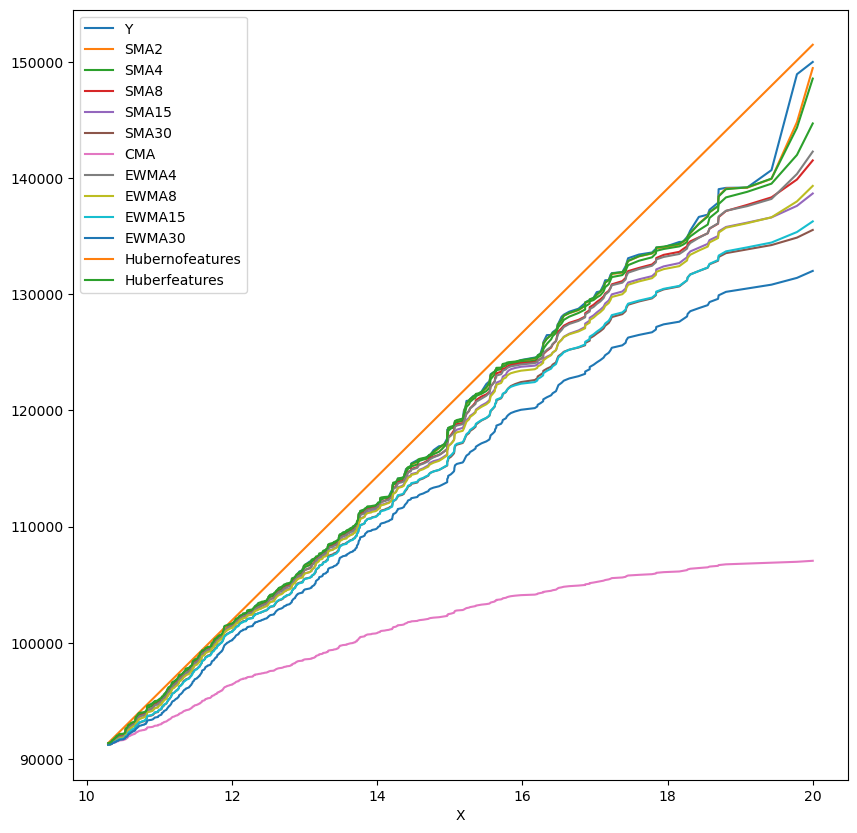

In [145]:
test_df['Hubernofeatures'] = huber_pedictions_no_features
test_df["Huberfeatures"] = huber_pedictions_features

test_df.plot(x="X", y=["Y","SMA2","SMA4","SMA8","SMA15" , "SMA30" , "CMA" ,"EWMA4" ,"EWMA8","EWMA15" ,"EWMA30" , 'Hubernofeatures' , 'Huberfeatures'],kind="line", figsize=(10, 10))
 


In [18]:
def calculate_multiple_rmse(df,rmse_columns,targetname):
    rmse_dict = {}
    for column in rmse_columns:
        realVals = df[targetname]
        predictedVals = df[column]
        mse = mean_squared_error(realVals, predictedVals, squared=False)
        rmse_dict[column] = mse
    return {k: v for k, v in sorted(rmse_dict.items(), key=lambda item: item[1])}


In [153]:
test_df = test_df.fillna(method="bfill")
train_df = train_df.fillna(method="bfill")
print(calculate_multiple_rmse(test_df,["SMA2","SMA4","SMA8","SMA15" , "SMA30" , "CMA" ,"EWMA4" ,"EWMA8","EWMA15" ,"EWMA30" , 'Hubernofeatures' , 'Huberfeatures'],"Y"))

{'SMA2': 206.6361994643709, 'Huberfeatures': 237.0533562997521, 'SMA4': 447.1340469676914, 'EWMA4': 719.3967831410464, 'SMA8': 724.0922080243653, 'SMA15': 1117.1168897821028, 'EWMA8': 1156.1380068779508, 'Hubernofeatures': 1758.205063950829, 'EWMA15': 1836.9799573137204, 'SMA30': 1870.8770274129768, 'EWMA30': 3102.8762123112483, 'CMA': 12018.806544513003}


## Many Features 
https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

In [2]:
dataframe_experiment = pd.read_csv('energydata_complete.csv')
dataframe_experiment['year'] = pd.to_datetime(dataframe_experiment['date']).dt.year
dataframe_experiment['month'] = pd.to_datetime(dataframe_experiment['date']).dt.month
dataframe_experiment['day'] = pd.to_datetime(dataframe_experiment['date']).dt.day
dataframe_experiment['hour'] = pd.to_datetime(dataframe_experiment['date']).dt.hour
dataframe_experiment['minute'] = pd.to_datetime(dataframe_experiment['date']).dt.minute
dataframe_experiment['second'] = pd.to_datetime(dataframe_experiment['date']).dt.second
dataframe_experiment = dataframe_experiment.drop('date', axis=1)

In [3]:
train_df, test_df = train_test_split(dataframe_experiment, test_size=0.6, shuffle=False)




X_train = train_df.iloc[:, :]
y_train = train_df.loc[:, 'Appliances']
X_train = train_df.drop('Appliances', axis=1)


X_test = test_df.iloc[:, :]
y_test = test_df.loc[:, 'Appliances']
X_test = test_df.drop('Appliances', axis=1)


In [21]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train, X_test, y_train, y_test)


100%|██████████| 42/42 [1:11:24<00:00, 102.02s/it]  


In [22]:
print(models)

                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
TweedieRegressor                             0.07       0.08  94.25   
ElasticNet                                   0.07       0.08  94.33   
GammaRegressor                               0.06       0.07  94.77   
HuberRegressor                               0.02       0.02  97.06   
HistGradientBoostingRegressor                0.02       0.02  97.19   
LinearSVR                                    0.01       0.02  97.34   
LGBMRegressor                                0.01       0.01  97.45   
OrthogonalMatchingPursuit                    0.01       0.01  97.62   
DummyRegressor                              -0.00      -0.00  98.11   
LassoLars                                   -0.00      -0.00  98.11   
NuSVR                                       -0.04      -0.03  99.74   
KNeighborsRegressor                         -0.04      -0.04  99.99   
Elasti

In [4]:
def objective(trial):
    
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 2, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=20,verbose=False)
    
    preds = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, preds,squared=False)
    
    return rmse



In [5]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-05-20 21:45:46,922] A new study created in memory with name: no-name-fadf178b-3880-4b90-8140-ce5690ab52a7
[I 2023-05-20 21:45:47,207] Trial 0 finished with value: 91.88237260477038 and parameters: {'reg_alpha': 9.608589463609558, 'reg_lambda': 0.009428697947873852, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 390, 'min_child_samples': 159, 'cat_smooth': 24}. Best is trial 0 with value: 91.88237260477038.
[I 2023-05-20 21:45:47,532] Trial 1 finished with value: 92.53348508173235 and parameters: {'reg_alpha': 0.03236128945752744, 'reg_lambda': 0.36882394393534185, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 289, 'min_child_samples': 253, 'cat_smooth': 35}. Best is trial 0 with value: 91.88237260477038.
[I 2023-05-20 21:45:48,010] Trial 2 finished with value: 92.18421108730185 and parameters: {'reg_alpha': 0.7642423045604565, 'reg_lambda': 0.009168331841357175, 'colsample_bytr

Number of finished trials: 150
Best trial: {'reg_alpha': 0.4713293279616887, 'reg_lambda': 0.0406979732818688, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 621, 'min_child_samples': 86, 'cat_smooth': 28}


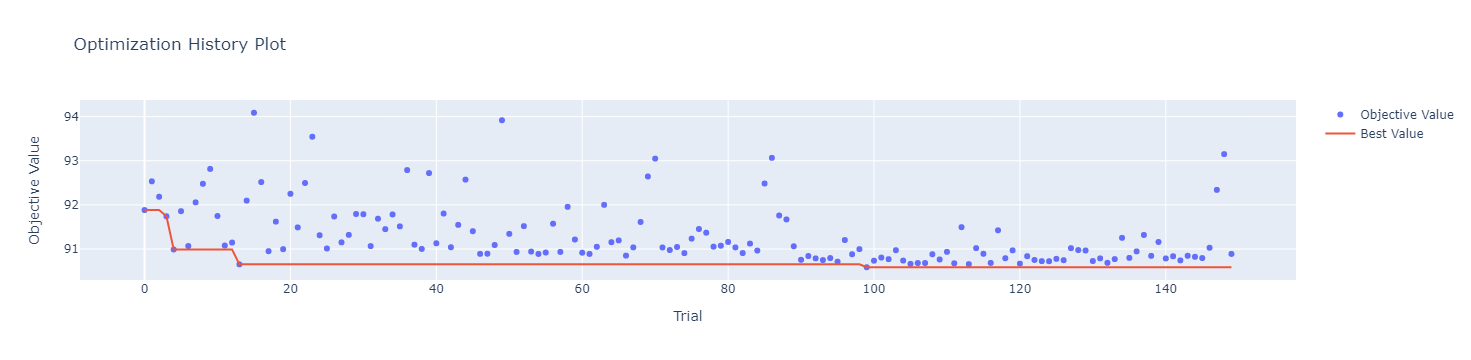

In [6]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

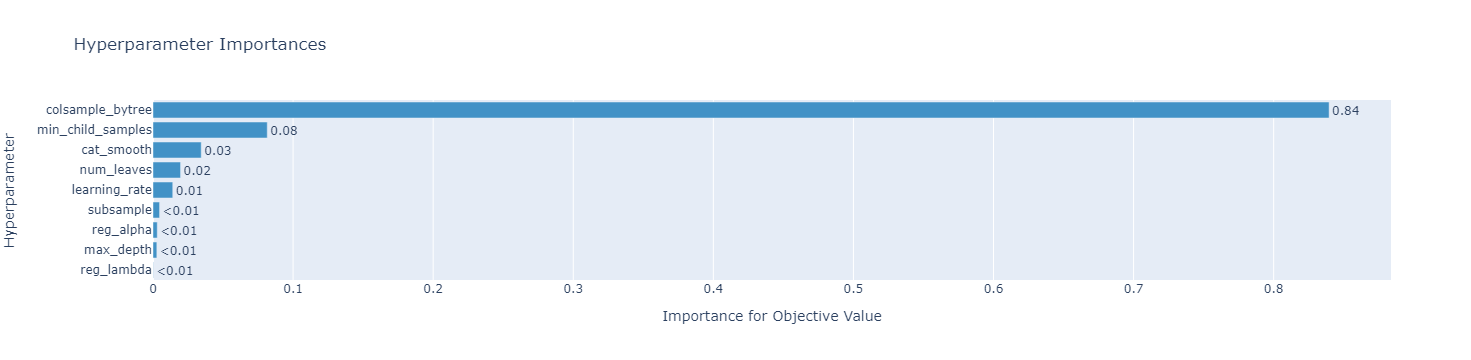

In [7]:
optuna.visualization.plot_param_importances(study)

In [8]:
tweedie = linear_model.TweedieRegressor().fit(X_train, y_train)
tweedie_pedictions_no_features = tweedie.predict(X_test)

In [9]:
params=study.best_params   
print(params)

{'reg_alpha': 0.4713293279616887, 'reg_lambda': 0.0406979732818688, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 621, 'min_child_samples': 86, 'cat_smooth': 28}


In [10]:
lgb = LGBMRegressor(**params).fit(X_train, y_train)
lgb_pedictions_no_features = lgb.predict(X_test)

In [11]:
train_df['SMA2'] = train_df['Appliances'].rolling(2).mean()
train_df['SMA4'] = train_df['Appliances'].rolling(4).mean()
train_df['SMA8'] = train_df['Appliances'].rolling(8).mean()

train_df['SMA15'] = train_df['Appliances'].rolling(15).mean()
train_df['SMA30'] = train_df['Appliances'].rolling(30).mean()



train_df['CMA'] = train_df['Appliances'].expanding().mean()


train_df['EWMA4'] = train_df['Appliances'].ewm(4).mean()
train_df['EWMA8'] = train_df['Appliances'].ewm(8).mean()

train_df['EWMA15'] = train_df['Appliances'].ewm(15).mean()
train_df['EWMA30'] = train_df['Appliances'].ewm(30).mean()



test_df['SMA2'] = test_df['Appliances'].rolling(2).mean()
test_df['SMA4'] = test_df['Appliances'].rolling(4).mean()
test_df['SMA8'] = test_df['Appliances'].rolling(8).mean()

test_df['SMA15'] = test_df['Appliances'].rolling(15).mean()
test_df['SMA30'] = test_df['Appliances'].rolling(30).mean()



test_df['CMA'] = test_df['Appliances'].expanding().mean()


test_df['EWMA4'] = test_df['Appliances'].ewm(4).mean()
test_df['EWMA8'] = test_df['Appliances'].ewm(8).mean()

test_df['EWMA15'] = test_df['Appliances'].ewm(15).mean()
test_df['EWMA30'] = test_df['Appliances'].ewm(30).mean()


backup = train_df['Appliances']
train_df=train_df.loc[:,train_df.columns!='Appliances']
train_df['Appliances']= backup


backup = test_df['Appliances']
test_df=test_df.loc[:,test_df.columns!='Appliances']
test_df['Appliances']= backup

test_df = test_df.fillna(method="bfill")
train_df = train_df.fillna(method="bfill")

X_train = train_df.iloc[:, :]
y_train = train_df.loc[:, 'Appliances']
X_train = train_df.drop('Appliances', axis=1)


X_test = test_df.iloc[:, :]
y_test = test_df.loc[:, 'Appliances']
X_test = test_df.drop('Appliances', axis=1)

In [12]:
def objective(trial):
    
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('cat_smooth', 2, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(X_test)
    
    rmse = mean_squared_error(y_test, preds,squared=False)
    
    return rmse

In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
params=study.best_params   
print(params)

[I 2023-05-20 21:47:28,753] A new study created in memory with name: no-name-0b1aea45-0b1d-444b-9a78-49ebef422528
[I 2023-05-20 21:47:31,756] Trial 0 finished with value: 31.599648730311433 and parameters: {'reg_alpha': 0.019562360234096975, 'reg_lambda': 0.0010514674169291264, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 564, 'min_child_samples': 49, 'cat_smooth': 100}. Best is trial 0 with value: 31.599648730311433.
[I 2023-05-20 21:47:35,998] Trial 1 finished with value: 34.538557142175186 and parameters: {'reg_alpha': 0.0876770722213004, 'reg_lambda': 0.5342931212147434, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 822, 'min_child_samples': 174, 'cat_smooth': 83}. Best is trial 0 with value: 31.599648730311433.
[I 2023-05-20 21:47:38,891] Trial 2 finished with value: 35.9144754505182 and parameters: {'reg_alpha': 0.003170683802238569, 'reg_lambda': 0.006867916981416822, 'colsamp

Number of finished trials: 150
Best trial: {'reg_alpha': 0.00627967917475814, 'reg_lambda': 0.008392442614301639, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 47, 'min_child_samples': 61, 'cat_smooth': 77}
{'reg_alpha': 0.00627967917475814, 'reg_lambda': 0.008392442614301639, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 47, 'min_child_samples': 61, 'cat_smooth': 77}


In [14]:
lgb = LGBMRegressor(**params).fit(X_train, y_train)
lgb_pedictions_features = lgb.predict(X_test)

In [15]:
tweedie = linear_model.TweedieRegressor().fit(X_train, y_train)
tweedie_pedictions_features = tweedie.predict(X_test)

<AxesSubplot:>

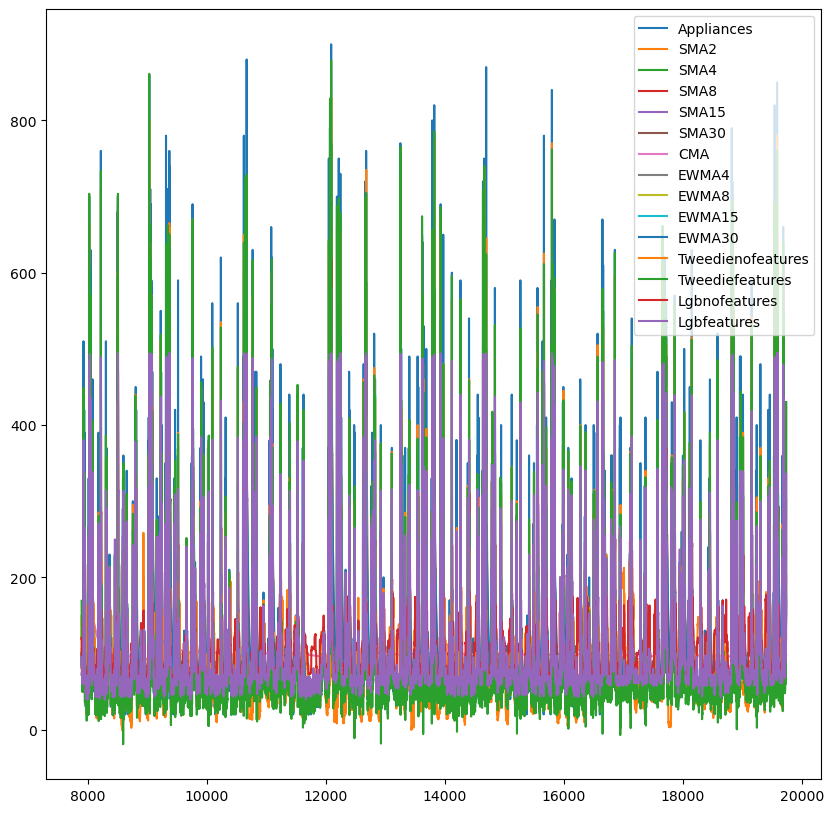

In [16]:
test_df['Tweedienofeatures'] = tweedie_pedictions_no_features
test_df["Tweediefeatures"] = tweedie_pedictions_features

test_df['Lgbnofeatures'] = lgb_pedictions_no_features
test_df["Lgbfeatures"] = lgb_pedictions_features

test_df.plot(use_index=True, y=['Appliances',"SMA2","SMA4","SMA8","SMA15" , "SMA30" , "CMA" ,"EWMA4" ,"EWMA8","EWMA15" ,"EWMA30" , 'Tweedienofeatures' , 'Tweediefeatures' , "Lgbnofeatures" , "Lgbfeatures"],kind="line", figsize=(10, 10))

In [19]:
test_df = test_df.fillna(method="bfill")
train_df = train_df.fillna(method="bfill")
print(calculate_multiple_rmse(test_df,["SMA2","SMA4","SMA8","SMA15" , "SMA30" , "CMA" ,"EWMA4" ,"EWMA8","EWMA15" ,"EWMA30" , 'Tweedienofeatures' , 'Tweediefeatures' , "Lgbnofeatures" , "Lgbfeatures"],'Appliances'))

{'Tweediefeatures': 31.546437849358515, 'SMA2': 35.0312032901008, 'Lgbfeatures': 40.9945272404199, 'SMA4': 58.62055887062029, 'EWMA4': 60.30680458768878, 'EWMA8': 70.45420867222279, 'SMA8': 71.22903384756715, 'SMA15': 77.08270442342108, 'EWMA15': 78.64091961465084, 'EWMA30': 86.38643328530924, 'SMA30': 86.55194903722322, 'Lgbnofeatures': 91.53775941913308, 'Tweedienofeatures': 97.28556297873862, 'CMA': 98.07196385728355}


<AxesSubplot:>

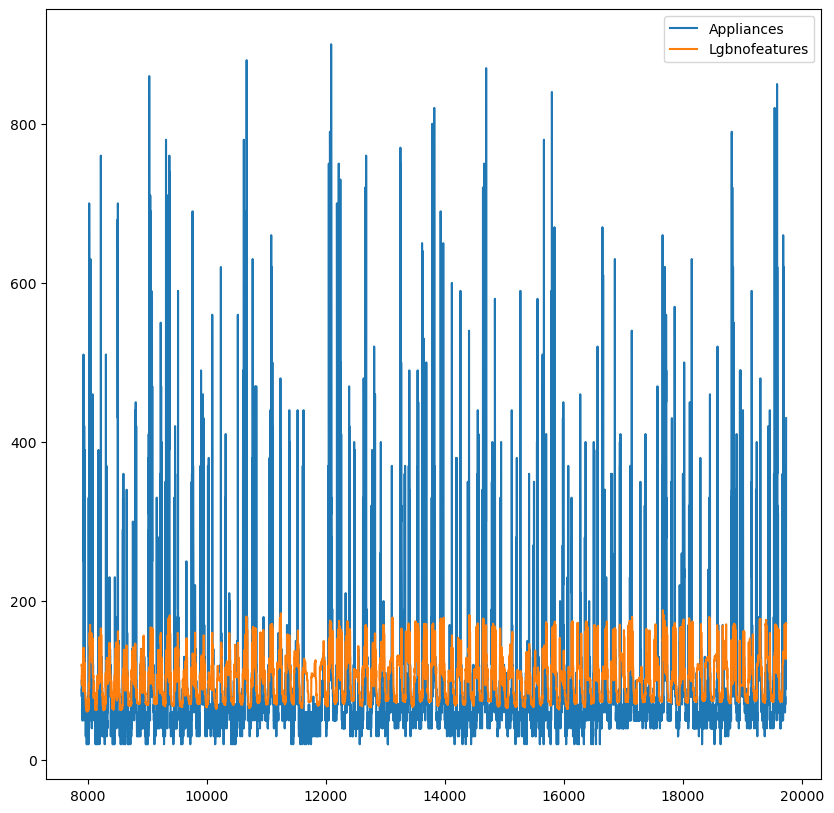

In [21]:
test_df.plot(use_index=True, y=['Appliances',"Lgbnofeatures"],kind="line", figsize=(10, 10))